In [5]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
os.chdir('/content/drive/MyDrive/eeg_data')


In [3]:
!pip install pywt
!pip install nilearn
!pip install dotmap
!pip install pyunicorn
!pip install scikit-mobility
!pip install mne
!pip install pyunicorn
!pip install umap-learn
!git clone https://github.com/pik-copan/pyunicorn.git
%cd pyunicorn
!pip install .
!pip install pyts

ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 77.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for pyunicorn (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pyunicorn
Failed to build pyunicorn
ERROR: Could not build wheels for pyunicorn, which is required to install pyproject.toml-based projects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.7/167.7 kB 3

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pywt

from io import StringIO
from pathlib import Path
from contextlib import redirect_stdout

from nilearn import plotting

from scipy.signal import welch
from scipy.signal import lfilter
from scipy.signal import resample
from scipy.signal import coherence

from sklearn.model_selection import train_test_split
######
from base.eeg import create_coherence_matrix, create_coherence_original_vs_reconstructed
from base.eeg import  generate_ar_process, generate_gaussian_process, generate_synthetic_eeg_data, plot_eeg_signals, generate_groups_synthetic_data_with_bands

from base.MyRC_ESN import MyESN
from base.MyRC_ESN import MyRC
from base.MyRC_ESN import print_prediction_results, calculate_dtw_distance, calculate_mean_absolute_error
from base.MyRC_ESN import calculate_mean_squared_error, calculate_pearson_correlation, normalize_time_series

# ***Si se quieren Crear datos sintéticos tanto con dinámica temporal como sin ella.***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import lfilter
from sklearn.model_selection import train_test_split

from base.eeg import create_coherence_matrix, create_coherence_original_vs_reconstructed
from base.eeg import  generate_ar_process, generate_gaussian_process, generate_synthetic_eeg_data, plot_eeg_signals, generate_groups_synthetic_data_with_bands

################
### GENERAMOS DATOS SINTETICOS
################
# Ejemplo datos sinteticos CON autorregresivo
n_subjects_per_group  = 20
n_samples_per_subject = 2000
n_channels            = 10
sr                    = 512  # frecuencia de muestreo

synthetic_data_auto, labels_auto = generate_synthetic_eeg_data (n_subjects_per_group, n_samples_per_subject, n_channels, sr)

print("Dimensiones de los datos sintéticos con autoregresivo:", synthetic_data_auto.shape)
print("Dimensiones de las etiquetas de los autoregresivos:", labels_auto.shape)

# Ejemplo datos sinteticos SIN autorregresivo
sr = 512
n_subjects             = 40  # Número total de sujetos
n_subjects_per_group   = 20
n_samples_per_subject  = 2000  # Número de muestras por sujeto
n_channels             = 10  # Número de canales EEG


synthetic_data, labels = generate_groups_synthetic_data_with_bands (n_subjects_per_group, n_samples_per_subject, n_channels, sr)

print("Dimensiones de los datos sintéticos:", synthetic_data.shape)
print("Dimensiones de las etiquetas:", labels.shape)

###############
# Dividir los sujetos en conjuntos de entrenamiento y prueba
Xo_train, Xo_test, yo_train, yo_test = train_test_split (synthetic_data_auto, labels_auto, test_size = 0.2, random_state = 42)

# Dividir los sujetos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split (synthetic_data, labels, test_size = 0.2, random_state = 42)

print("Dimensiones de los datos de entrenamiento:", X_train.shape)
print("Dimensiones de las etiquetas de entrenamiento:", y_train.shape)
print("Dimensiones de los datos de prueba:", X_test.shape)
print("Dimensiones de las etiquetas de prueba:", y_test.shape)

def convert_labels_to_words(labels):
    words = []
    for label in labels:
        if label[0] == 0 and label[1] == 1:
            words.append("young")
        elif label[0] == 1 and label[1] == 0:
            words.append("old")
        else:
            words.append("unknown")
    return words

words_labels = convert_labels_to_words (labels)
print("Dimensiones de las etiquetas words:", np.array (words_labels).shape)

Dimensiones de los datos sintéticos con autoregresivo: (40, 2000, 10)
Dimensiones de las etiquetas de los autoregresivos: (40, 2)
Dimensiones de los datos sintéticos: (40, 2000, 10)
Dimensiones de las etiquetas: (40, 2)
Dimensiones de los datos de entrenamiento: (32, 2000, 10)
Dimensiones de las etiquetas de entrenamiento: (32, 2)
Dimensiones de los datos de prueba: (8, 2000, 10)
Dimensiones de las etiquetas de prueba: (8, 2)
Dimensiones de las etiquetas words: (40,)


# ***Se almacenan en disco los datos sitéticos creados***

In [ ]:
import numpy as np
np.save('synthetic_data.npy', synthetic_data)
np.save('labels.npy', labels)
np.save('synthetic_data_auto.npy', synthetic_data_auto)
np.save('labels_auto.npy', labels_auto)


# ***Cargamos los datos sintéticos de disco***

In [8]:
synthetic_data_auto = np.load('synthetic_data_auto.npy')
labels_auto         = np.load('labels_auto.npy')
synthetic_data      = np.load('synthetic_data.npy')
labels              = np.load('labels.npy')

def convert_labels_to_words(labels):
    words = []
    for label in labels:
        if label[0] == 0 and label[1] == 1:
            words.append("young")
        elif label[0] == 1 and label[1] == 0:
            words.append("old")
        else:
            words.append("unknown")
    return words

words_labels = convert_labels_to_words (labels)
print("Dimensiones de las etiquetas words:", np.array (words_labels).shape)

Dimensiones de las etiquetas words: (40,)


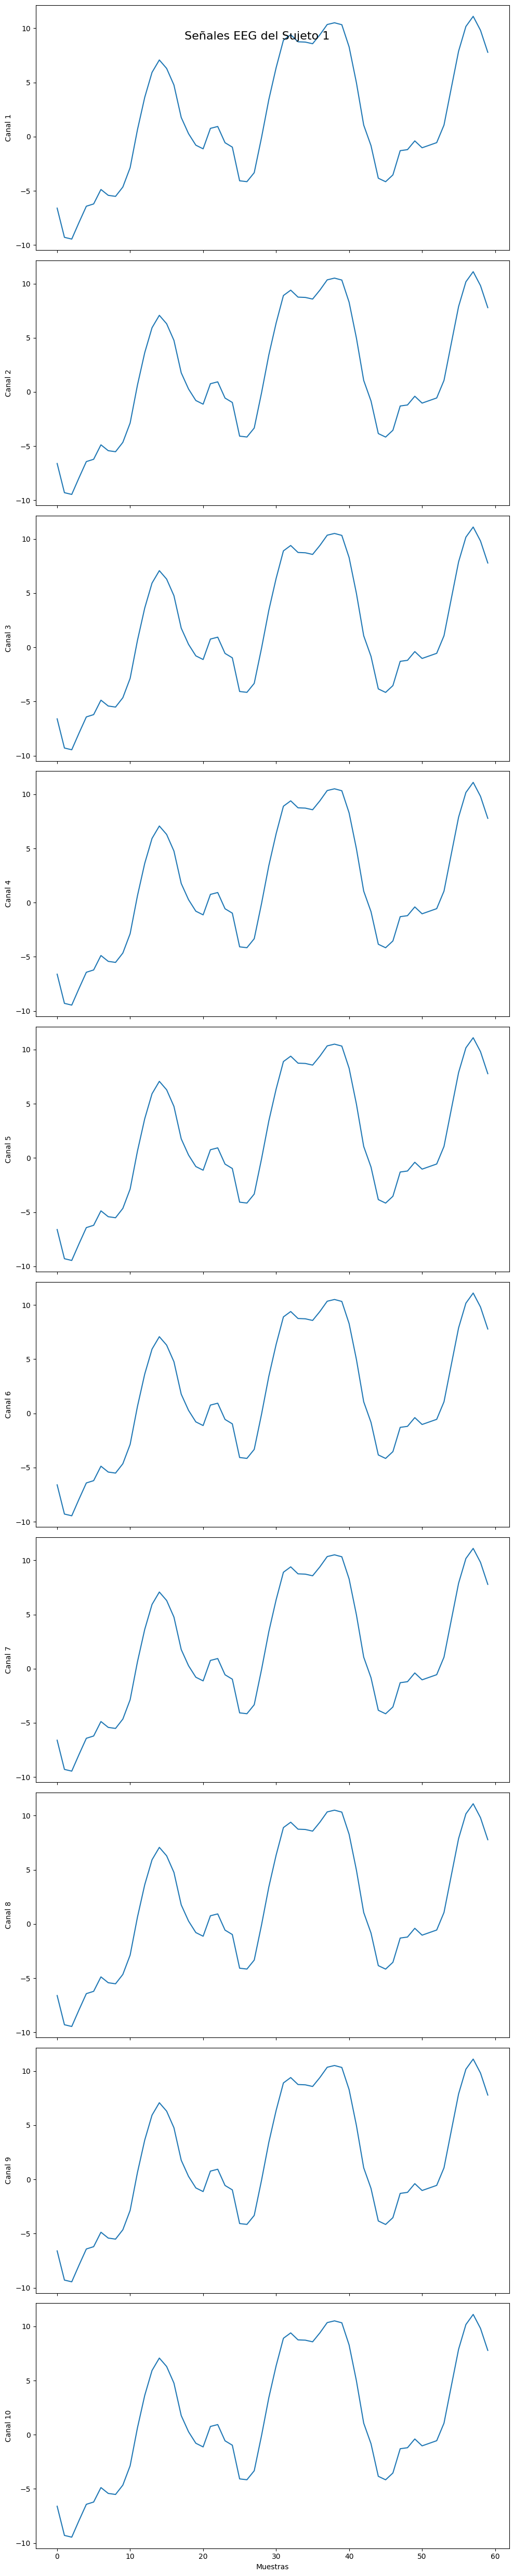

In [ ]:
plot_eeg_signals (1, synthetic_data)

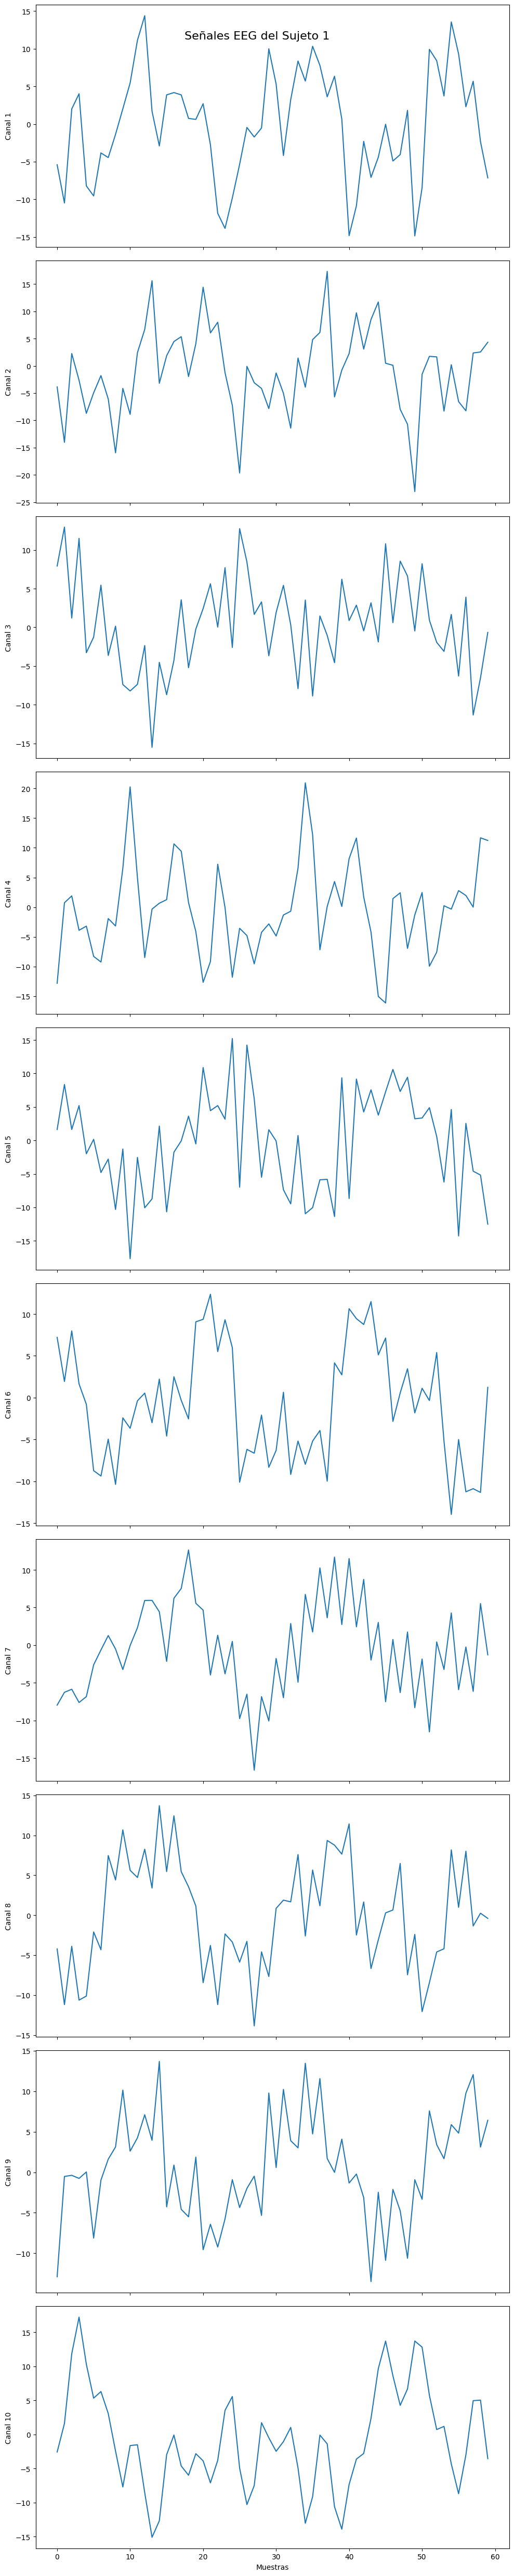

In [5]:
plot_eeg_signals (1, synthetic_data_auto)

 # Cluster

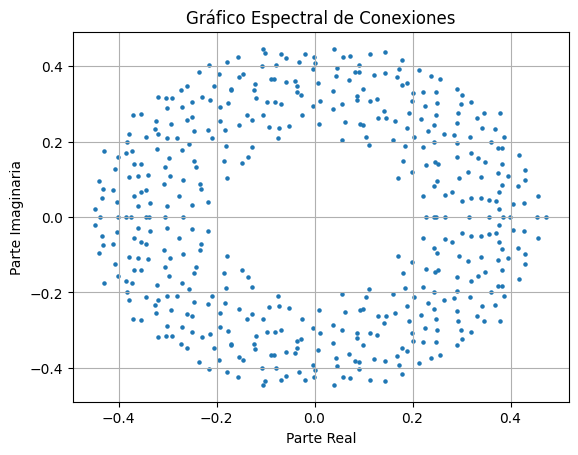

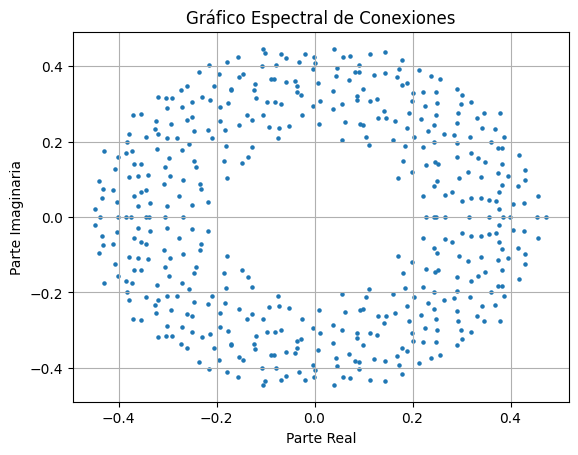

In [12]:
config_clus  = {
    'seed': 1,
    'init_type':'orthogonal',
    'init_std':0.01,
    'init_mean':0,
    'input_size':10,
    'input_scaling':0.1,
    'n_drop': 100,
    'washout':'rand',
    'use_input_bias':True,
    'use_input_layer':True,
    'bidir': True,
    'dimred_method': 'tenpca',
    'n_dim': 44,
    'mts_rep':'reservoir',
    'w_ridge_embedding':1.0,
    'readout_type': None,
    'threshold':0.5,
    'svm_kernel': 'linear',
    'svm_gamma': 0.005,
    'svm_C': 5.0,
    'w_ridge': 5.0,
    'num_epochs': 2000,
    'mlp_layout': (100, 100),
    'mlp_batch_size':32,
    'mlp_learning_rate':0.01,
    'mlp_learning_rate_type':'constant', # 'constant' or 'adaptive'
    'w_l2': 0.001,
    'n_internal_units': 480,
    'spectral_radius': 0.59,
    'leak': 0.4,
    'nonlinearity':'relu', # 'relu','tanh'
    'connectivity': 0.6,
    'noise_level': 0.1,
    'circle': False,
    'plasticity_synaptic':None,
    'theta_m':0.01,
    'plasticity_intrinsic':None,
    'learning_rate':0.9,
    'new_activation_function':'tanh',
    'excitability_factor':0.01,
    'device': 'cpu'
}


config_clus_o  = {
    'seed': 1,
    'init_type':'orthogonal',
    'init_std':0.01,
    'init_mean':0,
    'input_size':10,
    'input_scaling':0.1,
    'n_drop': 50,
    'washout':'init',
    'use_input_bias':True,
    'use_input_layer':True,
    'bidir': True,
    'dimred_method': 'tenpca',
    'n_dim': 50,
    'mts_rep':'reservoir',
    'w_ridge_embedding':1.0,
    'readout_type': None,
    'threshold':0.5,
    'svm_kernel': 'linear',
    'svm_gamma': 0.005,
    'svm_C': 5.0,
    'w_ridge': 5.0,
    'num_epochs': 2000,
    'mlp_layout': (100, 100),
    'mlp_batch_size':32,
    'mlp_learning_rate':0.01,
    'mlp_learning_rate_type':'constant', # 'constant' or 'adaptive'
    'w_l2': 0.001,
    'n_internal_units': 480,
    'spectral_radius': 0.59,
    'leak': 0.4,
    'nonlinearity':'relu', # 'relu','tanh'
    'connectivity': 0.6,
    'noise_level': 0.1,
    'circle': False,
    'plasticity_synaptic':None,
    'theta_m':0.01,
    'plasticity_intrinsic':None,
    'learning_rate':0.9,
    'new_activation_function':'tanh',
    'excitability_factor':0.01,
    'device': 'cpu'
}

model_clus   = MyESN  (config_clus)
model_clus_o = MyESN  (config_clus_o)
# Llamar al método para trazar el gráfico espectral
model_clus.plot_spectral_graph ()
# Llamar al método para trazar el gráfico espectral
model_clus_o.plot_spectral_graph ()

In [13]:
X = synthetic_data
Y = labels
print("Dimensiones de los datos sintéticos X :", X.shape)
print("Dimensiones de las etiquetas Y:", Y.shape)
Xo = synthetic_data_auto
Y  = labels
print("Dimensiones de los datos sintéticos Xo :", Xo.shape)
print("Dimensiones de las etiquetas Y:", Y.shape)

Dimensiones de los datos sintéticos X : (40, 2000, 10)
Dimensiones de las etiquetas Y: (40, 2)
Dimensiones de los datos sintéticos Xo : (40, 2000, 10)
Dimensiones de las etiquetas Y: (40, 2)


# Procesamos los datos sinteticos sin autorregresivo

In [14]:
my_rc_clus = MyRC (model_clus, config_clus )
result_rc  = my_rc_clus.fit (X)
# Devolvemos: Estados internos neuronas, Etados internos reducidos a PCA, Representación estados internos, Readout
rc_state, rc_dim_states, input_repr, output_redout_layer = result_rc

print (f'rc_state:{rc_state.shape}')
print (f'rc_dim_states:{rc_dim_states.shape}')
print (f'input_repr:{input_repr.shape}')
print (f'output_redout_layer:{output_redout_layer.shape}')

rc_state:(40, 3800, 480)
rc_dim_states:(40, 3800, 44)
input_repr:(40, 1980)
output_redout_layer:(40, 1980)


# Procesamos los datos sinteticos que contienen autorregresivo

In [15]:
my_rc_clus_o = MyRC (model_clus_o, config_clus_o)
result_rc_o  = my_rc_clus_o.fit (Xo)
# Devolvemos: Estados internos neuronas, Etados internos reducidos a PCA, Representación estados internos, Readout
rc_state_o, rc_dim_states_o, input_repr_o, output_redout_layer_o = result_rc_o

print (f'rc_state:{rc_state_o.shape}')
print (f'rc_dim_states:{rc_dim_states_o.shape}')
print (f'input_repr:{input_repr_o.shape}')
print (f'output_redout_layer:{output_redout_layer_o.shape}')

rc_state:(40, 3900, 480)
rc_dim_states:(40, 3900, 50)
input_repr:(40, 2550)
output_redout_layer:(40, 2550)


# **Salidas del RC**



* Representacion interna del RC antes de la PCA:  [num sujets, num samples, num neuronas] o [num sujets, num samples, 2 x num neuronas]

  - Con todos los transitorios:**rc_state_o**

* Representacion interna del RC despues de la PCA y antes de cambiar la representación interna:[num sujets, num samples, num reducción ndim]
  - Con todos los transitorios:**rc_dim_states_o**

* Representacion interna del RC despues de la PCA y representación interna, y antes del ReadOut: [num sujetos, num representación]
  - Con todos los transitorios:**input_repr_o**


* Salida del RC despues de aplicar Ridge y Redaout (*):[num sujetos, num readout]
  - Con todos los transitorios:**output_redout_layer_o**


          (*) Si readout es None entonces
          output_redout_layer_o == input_repr_o


In [ ]:
model_clus_o.config

{'seed': 1,
 'init_type': 'orthogonal',
 'init_std': 0.01,
 'init_mean': 0,
 'input_size': 10,
 'input_scaling': 0.1,
 'n_drop': None,
 'washout': 'init',
 'use_input_bias': True,
 'use_input_layer': True,
 'bidir': True,
 'dimred_method': 'tenpca',
 'n_dim': 44,
 'mts_rep': 'reservoir',
 'w_ridge_embedding': 1.0,
 'readout_type': None,
 'threshold': 0.5,
 'svm_kernel': 'linear',
 'svm_gamma': 0.005,
 'svm_C': 5.0,
 'w_ridge': 5.0,
 'num_epochs': 2000,
 'mlp_layout': (10, 10),
 'w_l2': 0.001,
 'n_internal_units': 480,
 'spectral_radius': 0.59,
 'leak': 0.4,
 'nonlinearity': 'relu',
 'connectivity': 0.6,
 'noise_level': 0.1,
 'circle': False,
 'plasticity_synaptic': None,
 'theta_m': 0.01,
 'plasticity_intrinsic': None,
 'learning_rate': 0.9,
 'new_activation_function': 'tanh',
 'excitability_factor': 0.01,
 'device': 'cpu'}

# Clusters Datos autorregresivos.

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             classification_report)

def evaluate_clustering(labels, labels_pred):
    """
    Calcula y muestra varias métricas de evaluación para el clustering, incluyendo la matriz de confusión,
    frecuencia, precisión, recall, F1 score, ROC AUC score y la curva ROC. También muestra el reporte de clasificación.

    Args:
    labels (array-like): Etiquetas reales.
    labels_pred (array-like): Etiquetas predichas por el modelo de clustering.
    """

    # Calcular la matriz de confusión
    cm = confusion_matrix(labels, labels_pred)
    print("Confusion Matrix:")
    print(cm)

    # Graficar la matriz de confusión
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=np.unique(labels), yticklabels=np.unique(labels))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Calcular frecuencia y precisión
    fq = np.sum(cm, axis=0) / np.sum(cm)
    accuracy = np.trace(cm) / np.sum(cm)
    print("Frequency:", fq)
    print("Accuracy:", accuracy)

    # Calcular otras métricas
    precision = precision_score(labels, labels_pred, average='weighted')
    recall = recall_score(labels, labels_pred, average='weighted')
    f1 = f1_score(labels, labels_pred, average='weighted')
    roc_auc = roc_auc_score(labels, labels_pred)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)

    # Calcular la curva ROC
    fpr, tpr, _ = roc_curve(labels, labels_pred)

    # Graficar la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Reporte de clasificación
    report = classification_report(labels, labels_pred)
    print("Classification Report:")
    print(report)

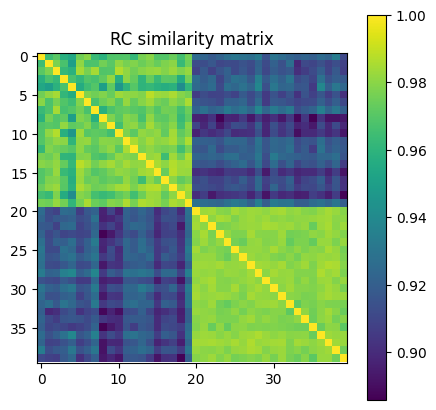

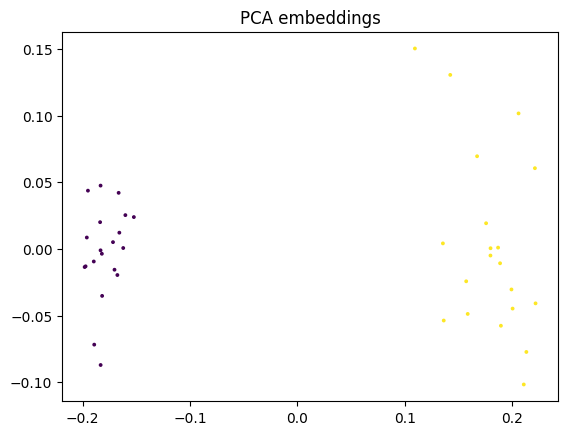

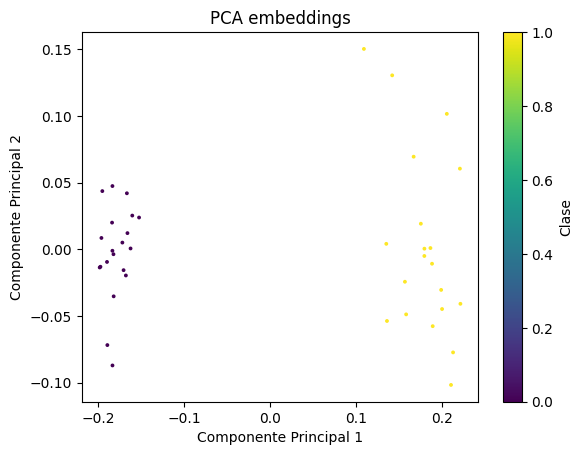

Varianza explicada por el Componente Principal 1: 0.9210
Varianza explicada por el Componente Principal 2: 0.0790
Found 2 clusters
Normalized Mutual Information (v-score): 1.000


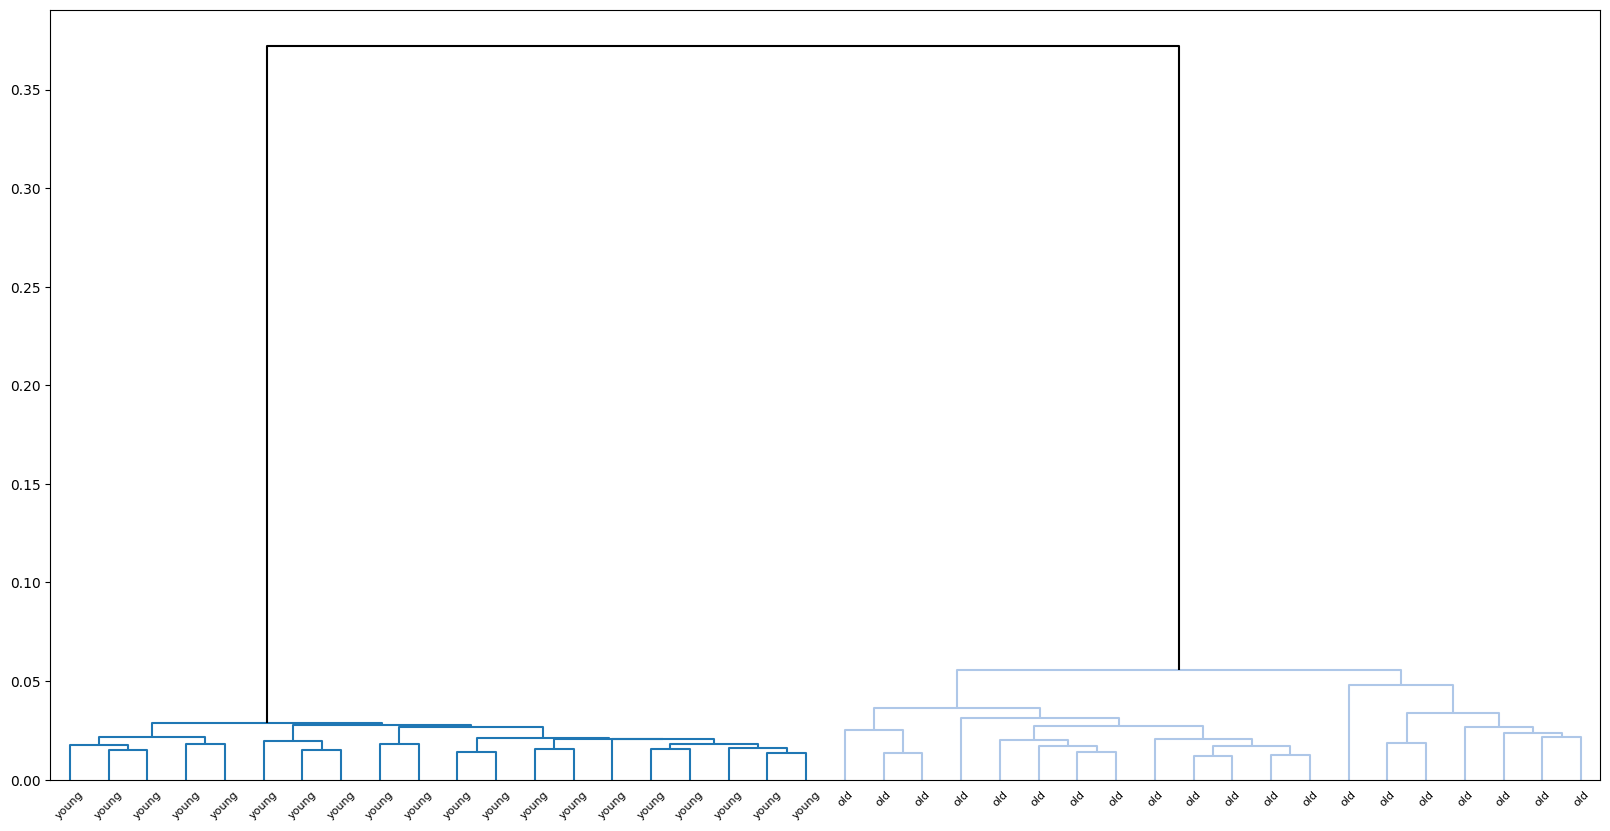

N. clusters:  2
Confusion Matrix:
[[20  0]
 [ 0 20]]


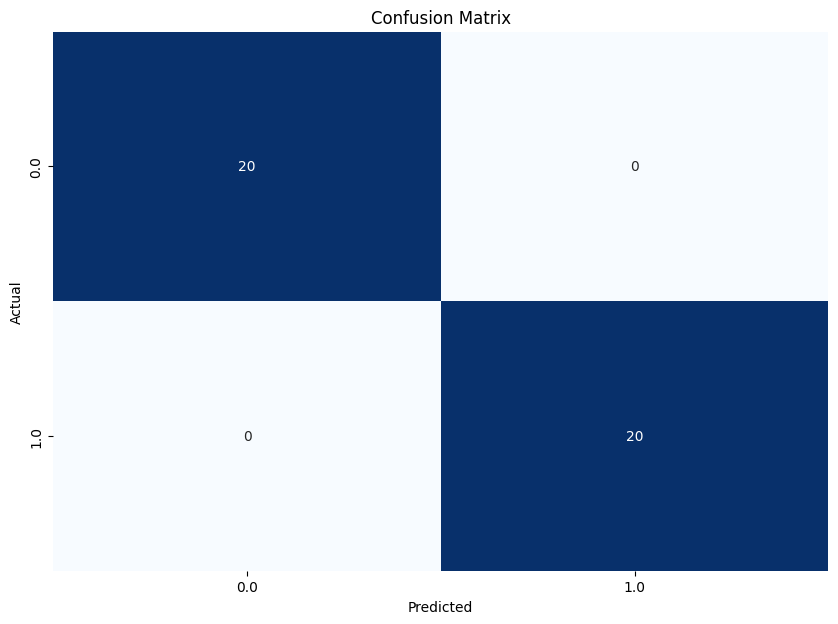

Frequency: [0.5 0.5]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0


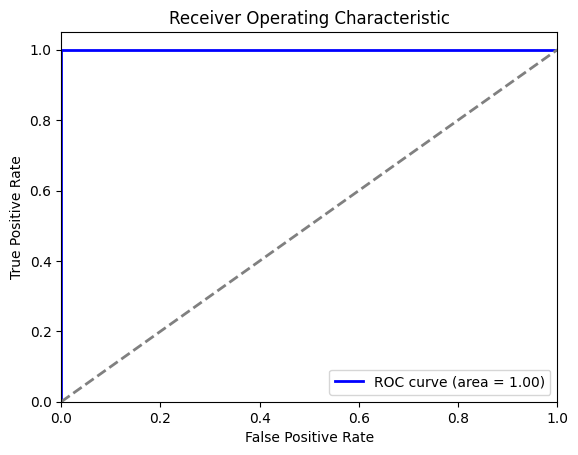

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [17]:
# General imports

import scipy.io
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm

from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.metrics import v_measure_score
from sklearn.decomposition import KernelPCA
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score,
                             precision_score, recall_score, f1_score,
                             accuracy_score, classification_report)

# Set the colormap for the histogram plot
cmap = cm.tab20(np.linspace(0, 1, 12))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

# Fix the random seed for reproducibility
np.random.seed(0)


mts_representations_o = input_repr_o
# Compute a similarity matrix from the cosine similarity of the representations
similarity_matrix = cosine_similarity (mts_representations_o)

# Normalize the similarity in [0,1]
similarity_matrix = (similarity_matrix + 1.0)/2.0

# Plot similarity matrix
fig =  plt.figure(figsize=(5,5))
h = plt.imshow(similarity_matrix)
plt.title("RC similarity matrix")
plt.colorbar(h)
plt.show()

# Reducción de dimensionalidad con Kernel PCA
kpca = KernelPCA(n_components=2, kernel='precomputed')
embeddings_pca = kpca.fit_transform(similarity_matrix)
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=Y[:,0], s=3)
plt.title("PCA embeddings")
plt.show()

# Reducción de dimensionalidad con Kernel PCA
# kpca = KernelPCA(kernel='precomputed')
# embeddings_pca = kpca.fit_transform(similarity_matrix)

# Obtener los autovalores (varianza explicada)
eigenvalues = kpca.eigenvalues_

# Calcular la varianza total (suma de los autovalores)
total_variance = np.sum(eigenvalues)

# Calcular la varianza explicada por cada componente
explained_variance_ratio = eigenvalues / total_variance

# Graficar los resultados (solo para los dos primeros componentes)
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=Y[:, 0], s=3)
plt.title("PCA embeddings")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label='Clase')
plt.show()

# Mostrar la varianza explicada por cada componente
for i, ev in enumerate(explained_variance_ratio):
    print(f"Varianza explicada por el Componente Principal {i+1}: {ev:.4f}")

# Compute Dissimilarity matrix
Dist = 1.0 - similarity_matrix
np.fill_diagonal(Dist, 0) # due to numerical errors, the diagonal might not be 0

# Hierarchical clustering
distArray = ssd.squareform (Dist)
Z = linkage(distArray, 'ward')
clust = fcluster(Z, t = 0.2, criterion="distance")
print("Found %d clusters"%len(np.unique(clust)))
# Evaluate the agreement between class and cluster labels
nmi = v_measure_score(Y[:,0], clust)
print("Normalized Mutual Information (v-score): %.3f"%nmi)

# Plot dendrogram
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=0.2, labels = words_labels, above_threshold_color='k')
plt.show()
print("N. clusters: ", np.unique(dn['color_list']).shape[0]-1)


# Obtener las etiquetas reales y predichas
labels      = labels_auto [:,0]   # Asegúrate de que 'labels_auto' contenga las etiquetas correctas
labels_pred = clust - 1           # Este es solo un ejemplo, reemplaza con tus etiquetas de clustering jerárquico

# Calcular la matriz de confusión y métricas relacionadas
evaluate_clustering (labels, labels_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


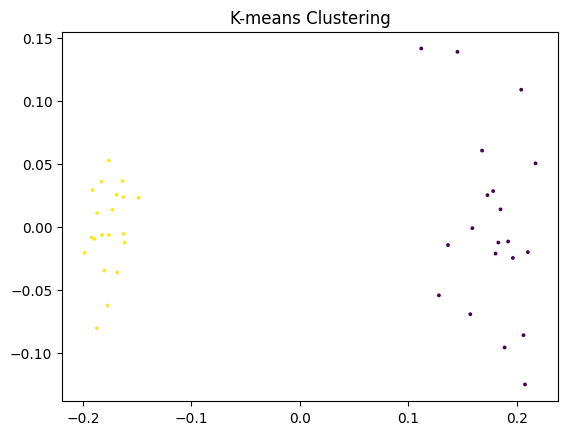

Confusion Matrix:
[[20  0]
 [ 0 20]]


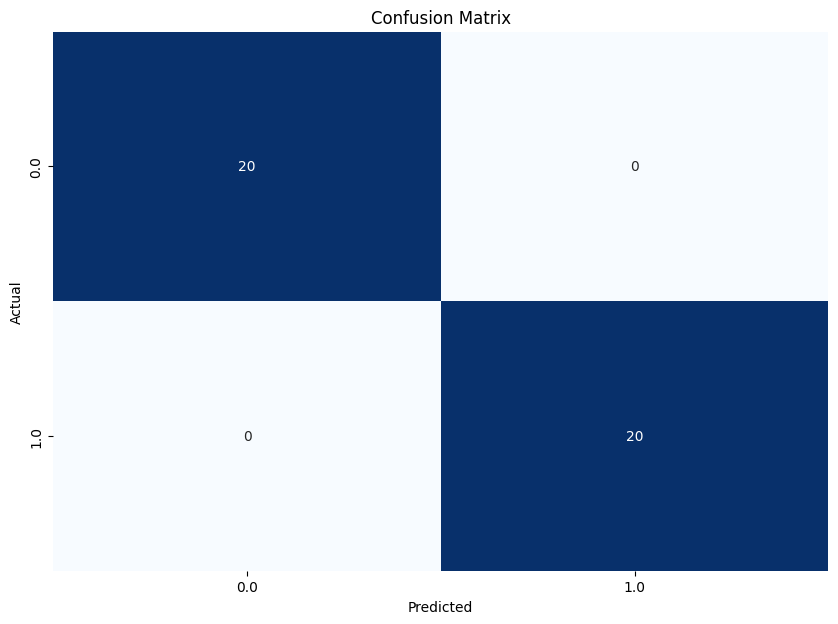

Frequency: [0.5 0.5]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0


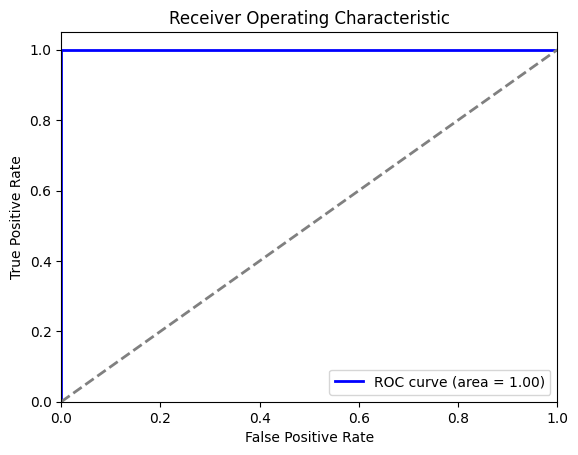

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [ ]:

# Dist = 1.0 - similarity_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score,
                             precision_score, recall_score, f1_score,
                             accuracy_score, classification_report)
import matplotlib.pyplot as plt
import numpy as np

# Compute Dissimilarity matrix
Dist = 1.0 - similarity_matrix
np.fill_diagonal (Dist, 0) # due to numerical errors, the diagonal might not be 0

# K-means clustering with 2 clusters
kmeans        = KMeans (n_clusters = 2, random_state = 0)
labels_pred = kmeans.fit_predict (Dist)

# Plot K-means clusters
plt.scatter (embeddings_pca [:, 0], embeddings_pca [:, 1], c=labels_pred, s = 3)
plt.title ("K-means Clustering")
plt.show ()

labels = labels_auto [:, 1]

# Calcular la matriz de confusión y métricas relacionadas
evaluate_clustering (labels, labels_pred)

# Clusters sin autoregresivo y con diferentes amplitudes

input_repr:(40, 1980)


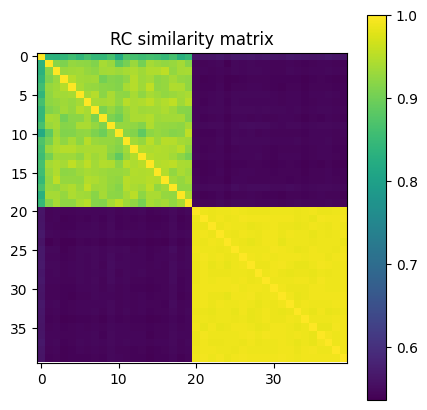

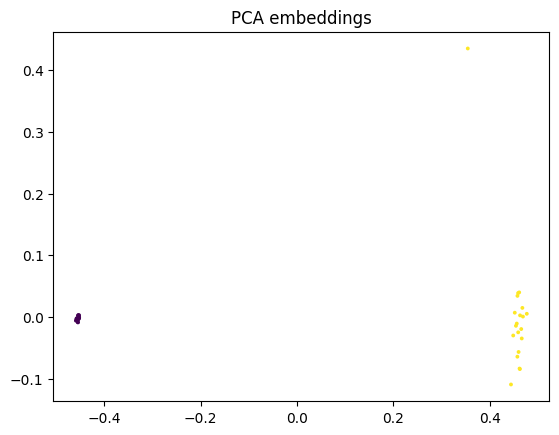

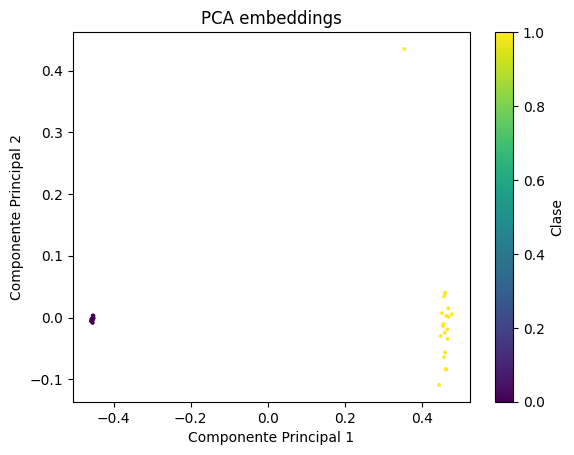

Varianza explicada por el Componente Principal 1: 0.9729
Varianza explicada por el Componente Principal 2: 0.0271
Found 2 clusters
Normalized Mutual Information (v-score): 1.000


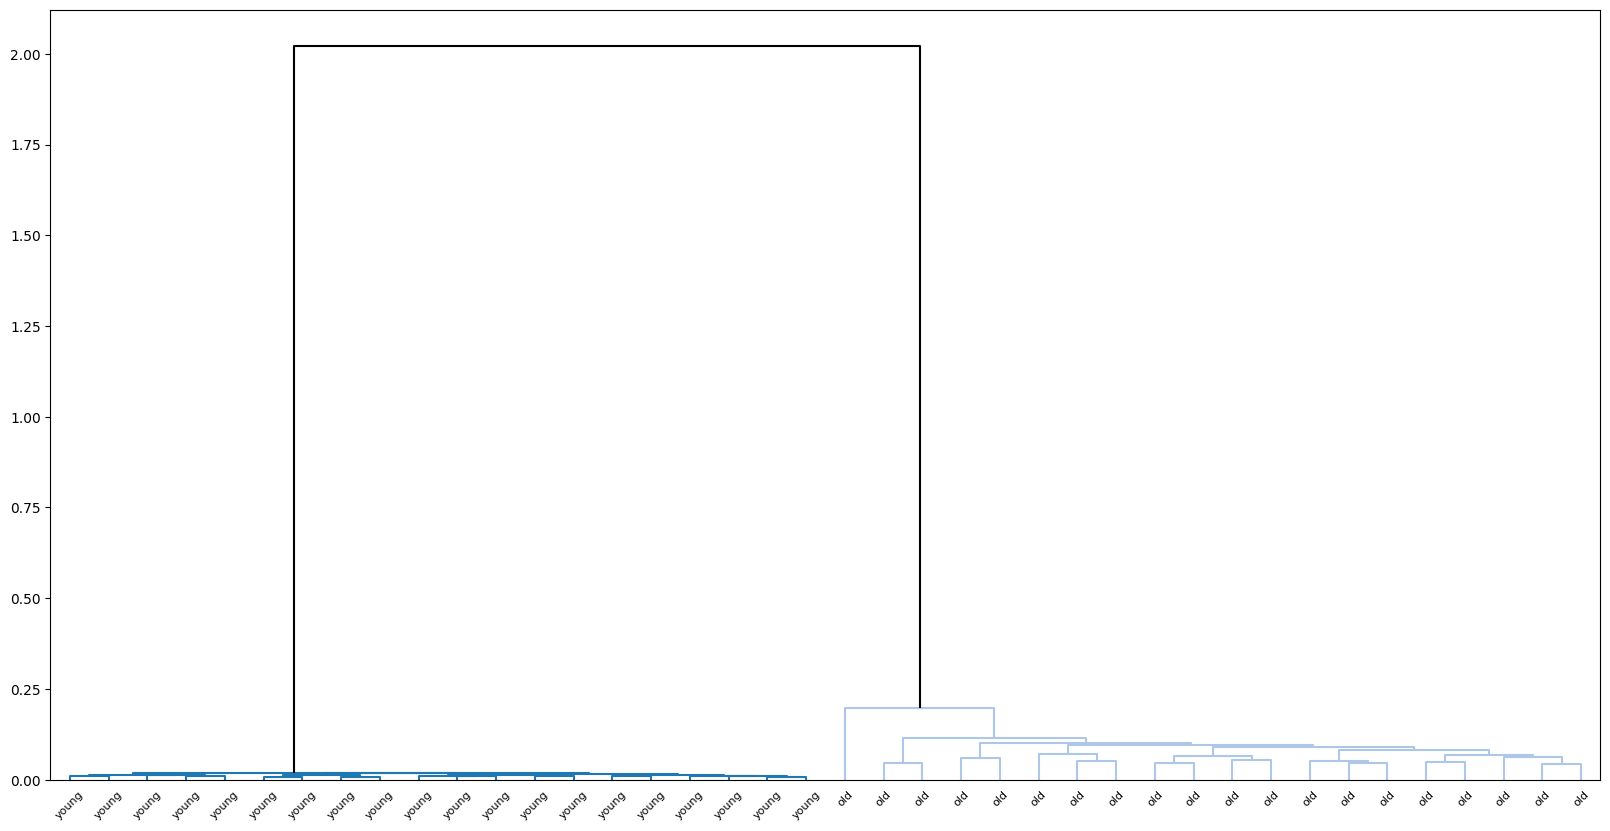

N. clusters:  2
Confusion Matrix:
[[20  0]
 [ 0 20]]


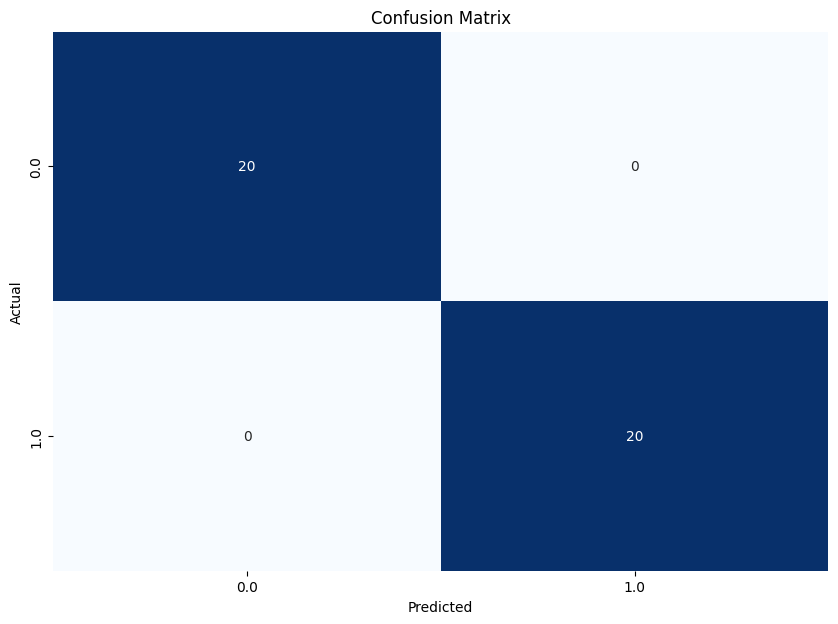

Frequency: [0.5 0.5]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0


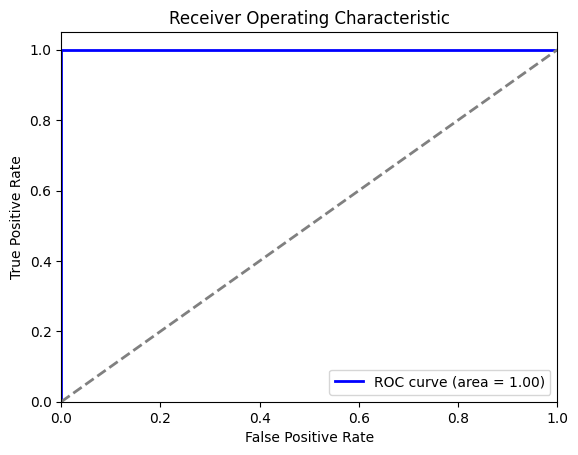

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [15]:
# General imports
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import scipy.spatial.distance as ssd
import matplotlib as mpl
from matplotlib.pyplot import cm
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import v_measure_score

# Set the colormap for the histogram plot
cmap = cm.tab20(np.linspace(0, 1, 12))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

# Fix the random seed for reproducibility
np.random.seed(0)

print(f'input_repr:{input_repr.shape}')

mts_representations = input_repr
# Compute a similarity matrix from the cosine similarity of the representations
similarity_matrix = cosine_similarity (mts_representations)

# Normalize the similarity in [0,1]
similarity_matrix = (similarity_matrix + 1.0)/2.0

# Plot similarity matrix
fig =  plt.figure(figsize=(5,5))
h = plt.imshow(similarity_matrix)
plt.title("RC similarity matrix")
plt.colorbar(h)
plt.show()

# Reducción de dimensionalidad con Kernel PCA
kpca = KernelPCA(n_components=2, kernel='precomputed')
embeddings_pca = kpca.fit_transform(similarity_matrix)
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=Y[:,0], s=3)
plt.title("PCA embeddings")
plt.show()
# Obtener los autovalores (varianza explicada)
eigenvalues = kpca.eigenvalues_

# Calcular la varianza total (suma de los autovalores)
total_variance = np.sum(eigenvalues)

# Calcular la varianza explicada por cada componente
explained_variance_ratio = eigenvalues / total_variance

# Graficar los resultados (solo para los dos primeros componentes)
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=Y[:, 0], s=3)
plt.title("PCA embeddings")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label='Clase')
plt.show()

# Mostrar la varianza explicada por cada componente
for i, ev in enumerate(explained_variance_ratio):
    print(f"Varianza explicada por el Componente Principal {i+1}: {ev:.4f}")

# Compute Dissimilarity matrix
Dist = 1.0 - similarity_matrix
np.fill_diagonal(Dist, 0) # due to numerical errors, the diagonal might not be 0

# Hierarchical clustering
distArray = ssd.squareform (Dist)
Z = linkage(distArray, 'ward')
clust = fcluster(Z, t = 0.2, criterion="distance")
print("Found %d clusters"%len(np.unique(clust)))
# Evaluate the agreement between class and cluster labels
nmi = v_measure_score(Y[:,0], clust)
print("Normalized Mutual Information (v-score): %.3f"%nmi)

# Plot dendrogram
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=0.2, labels = words_labels, above_threshold_color='k')
plt.show()
print("N. clusters: ", np.unique(dn['color_list']).shape[0]-1)

# Obtener las etiquetas reales y predichas
labels      = labels_auto [:,0]   # Asegúrate de que 'labels_auto' contenga las etiquetas correctas
labels_pred = clust - 1           # Este es solo un ejemplo, reemplaza con tus etiquetas de clustering jerárquico

# Calcular la matriz de confusión y métricas relacionadas
evaluate_clustering (labels, labels_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


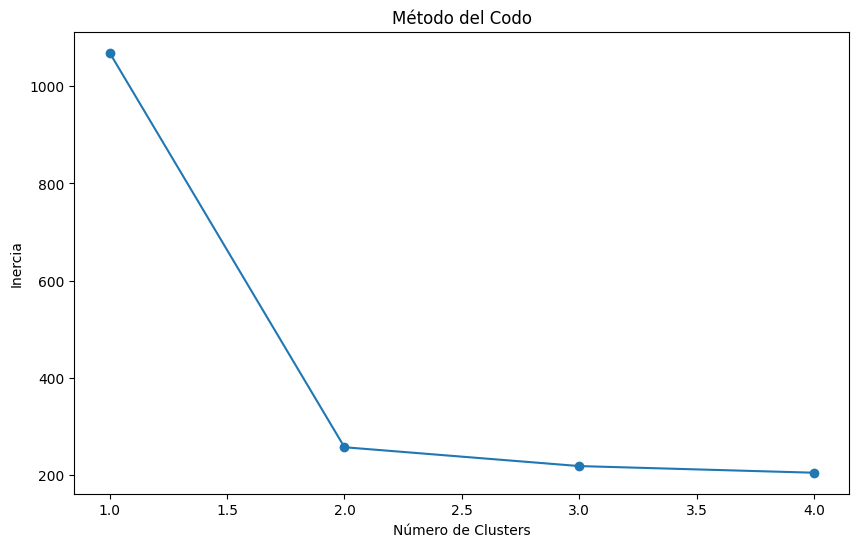

 Número de clusters óptimo:  2


In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_optimal_clusters(data, max_k):
    """
    Encuentra el número óptimo de clusters utilizando el método del codo.

    Args:
    - data (numpy.ndarray): Los datos de entrada.
    - max_k (int): El número máximo de clusters a probar.

    Returns:
    - optimal_k (int): El número óptimo de clusters.
    """

    # Lista para almacenar los valores de inercia
    inertia_values = []

    for k in range(1, max_k + 1):
        # Entrenar el modelo de KMeans
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(data)

        # Calcular la inercia y añadirla a la lista
        inertia_values.append(kmeans.inertia_)


    # Plot del método del codo
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), inertia_values, marker='o')
    plt.title('Método del Codo')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inercia')
    plt.show()


    # Encontrar el punto de codo
    # En este caso, el punto de codo es donde la derivada segunda de la inercia es máxima
    acceleration = np.diff(inertia_values, 2)  # Derivada segunda de la inercia
    optimal_k = acceleration.argmax() + 2  # El número óptimo de clusters

    return optimal_k


n_clust = find_optimal_clusters (data = mts_representations_o, max_k = 4)

print (f' Número de clusters óptimo:  {n_clust}')

# **Gráficos de recurrencia**
Ahora se tienen los sujetyos sinteticos con misma ampitud (=1)

Se utiliza la representacion interna del RC antes del PCA.: rc_dim_states_o


GRAFICOS DE RECURRENCIA

Comprobaremos si la representación interna del RC recoge las características o patrones de la dinámica temporal de lsas señales temporales de los canales EEG de cada sujeto.

La idea es conprobar si existen unos patrones similares entre sujetos jovenes adultos y distintivos entre éstos y los sujetos mayores.

Para el cálculo de las gráficas de recurrencia utilizarémos dos alternativas:

*{¿Qué es una Gráfica Recurrente?}*

Una gráfica recurrente es una representación bidimensional que muestra los momentos en los que un sistema dinámico retorna a estados similares. Se basa en el concepto de "recurrencia", que es la tendencia de los sistemas dinámicos a visitar los mismos estados o estados similares a lo largo del tiempo.

*{Definición Formal}*

Para una serie temporal $(\{x_i\}_{i=1}^N)$, la gráfica recurrente se define como una matriz $(R)$ donde cada elemento $(R_{i,j})$ se determina de la siguiente manera:

$$
R_{i,j} = \Theta (\epsilon - \| \mathbf{x}_i - \mathbf{x}_j \|)
$$

Aquí:

* $(mathbf{x}_i)$ y $(mathbf{x}_j)$ son los puntos en el espacio de fases (generalmente reconstruido mediante el método de retardos).
* $(| \cdot \|)$ es una norma (comúnmente la norma euclidiana).
* $(\epsilon)$ es un umbral de recurrencia.
* $(\Theta)$ es la función escalón de Heaviside, que es 1 si el argumento es positivo y 0 en caso contrario.


*{Cómo se Utiliza una Gráfica Recurrente}*


* *{Reconstrucción del Espacio de Fases}*: Si los datos originales están en una serie temporal unidimensional, se reconstruye el espacio de fases utilizando el método de retrasos (delay embedding).
    
  $$
  \mathbf{x}(t) = [x(t), x(t+\tau), x(t+2\tau), \dots, x(t+(m-1)\tau)]
  $$
  
  Donde $(\tau)$ es el retraso de tiempo y $(m)$ es la dimensión de incrustación.
    
* **{Construcción de la Matriz de Recurrencia}**: Con el espacio de fases reconstruido, se calcula la matriz de recurrencia usando la definición mencionada.
    
* **Visualización}**: La matriz de recurrencia se visualiza como una imagen donde los valores de 1 (o verdaderos) se representan como puntos negros y los valores de 0 (o falsos) se representan como puntos blancos.


*{Interpretación de las Gráficas Recurrentes}*


* **{Diagonales}**: Indican que el sistema sigue un patrón similar en el tiempo, mostrando periodicidad o recurrencia.
* **{Verticales/Horizontales}**: Sugieren estados estacionarios o lentos cambios en la dinámica.
* **{Blancos}**: Áreas sin recurrencia, indicando transiciones o cambios en el estado del sistema.
* **{Estructuras complejas}**: Pueden revelar dinámicas caóticas o comportamientos no lineales complejos.


*{Aplicaciones}*


* **{Análisis de Sistemas Dinámicos}**: Útil en física, biología y economía para estudiar sistemas caóticos y complejos.
* **{Medicina}**: Análisis de señales fisiológicas, como electrocardiogramas (ECG) o electroencefalogramas (EEG).
* **{Climatología}**: Estudio de patrones climáticos y detección de cambios en el clima.
* **{Ingeniería}**: Análisis de vibraciones y detección de fallos en maquinaria.


*{Herramientas y Software}*

Existen varias herramientas y software para generar y analizar gráficas recurrentes, tales como:


* **{Matlab}**: Posee funciones específicas para crear gráficas recurrentes.
* **{Python}**: Bibliotecas como {pyunicorn} y {recurrence\_plot} en {scikit-mobility} pueden ser utilizadas.
* **{R}**: Paquetes como \texttt{tseriesChaos} ofrecen funciones para análisis de series temporales y gráficas recurrentes.


***{Pasos Generales}***


* **{Obtener la salida de tu ESN}**: Ejecuta tu ESN para obtener la serie temporal de salida que deseas analizar.

* **{Formatear los datos}**: Asegúrate de que los datos están en el formato adecuado (array de Numpy, por ejemplo).

* **{Crear la gráfica recurrente}**: Utiliza {RecurrencePlot} de {pyunicorn} o {recurrence\_plot} de {scikit-mobility} para generar la gráfica recurrente.

* **{Visualizar y analizar}**: Usa funciones de visualización (como {plot()} en {pyunicorn} o {plt.imshow()} en {scikit-mobility}) para visualizar la gráfica recurrente y analizar los patrones.


***{Interpretación de las Gráficas Recurrentes}***

Una vez generada la gráfica recurrente, puedes buscar patrones como:

* **{Diagonales}**: Indican períodos de recurrencia y pueden sugerir periodicidad.
* **{Estructuras complejas}**: Indican comportamiento caótico o no lineal.
* **{Áreas blancas}**: Representan transiciones entre diferentes estados.
$$

***{Conclusión}***

Utilizar gráficas recurrentes con la salida de tu ESN es una excelente manera de visualizar y analizar los patrones dinámicos en tus señales temporales. \texttt{pyunicorn} y \texttt{scikit-mobility} son herramientas útiles que pueden facilitar este análisis, proporcionando visualizaciones claras y detalladas de las recurrencias en tus datos.


***{Conclusión}***

Las gráficas recurrentes son una poderosa herramienta para analizar series temporales y descubrir patrones dinámicos. Al representar visualmente la recurrencia de estados similares, permiten identificar la estructura y dinámica interna de sistemas complejos y no lineales. Su uso se extiende a diversas disciplinas, desde la física hasta la medicina, ofreciendo una metodología versátil para el análisis de datos temporales.


In [5]:
!git clone https://github.com/pik-copan/pyunicorn.git
%cd pyunicorn
!pip install .


fatal: destination path 'pyunicorn' already exists and is not an empty directory.
/content/drive/MyDrive/eeg_data/pyunicorn
Processing /content/drive/MyDrive/eeg_data/pyunicorn
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyunicorn: filename=pyunicorn-0.7.1a1-cp310-cp310-linux_x86_64.whl size=2558090 sha256=49a9bd42a6f6286691f07be941933a75c273886365df12fae0a192c2622cce5b
  Stored in directory: /tmp/pip-ephem-wheel-cache-_c1wku7f/wheels/8e/c0/f6/05ddc6b88f7e500de4bef6b26f86e4b01ecd00a6b40f0668b8
Successfully built pyunicorn
  Attempting uninstall: pyunicorn
    Found existing installation: pyunicorn 0.7.1a1
    Uninstalling pyunicorn-0.7.1a1:
      Successfully uninstalled pyunicorn-0.7.1a1


In [20]:
!pip install pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 7.8 MB/s eta 0:00:00


(40, 4000, 50)


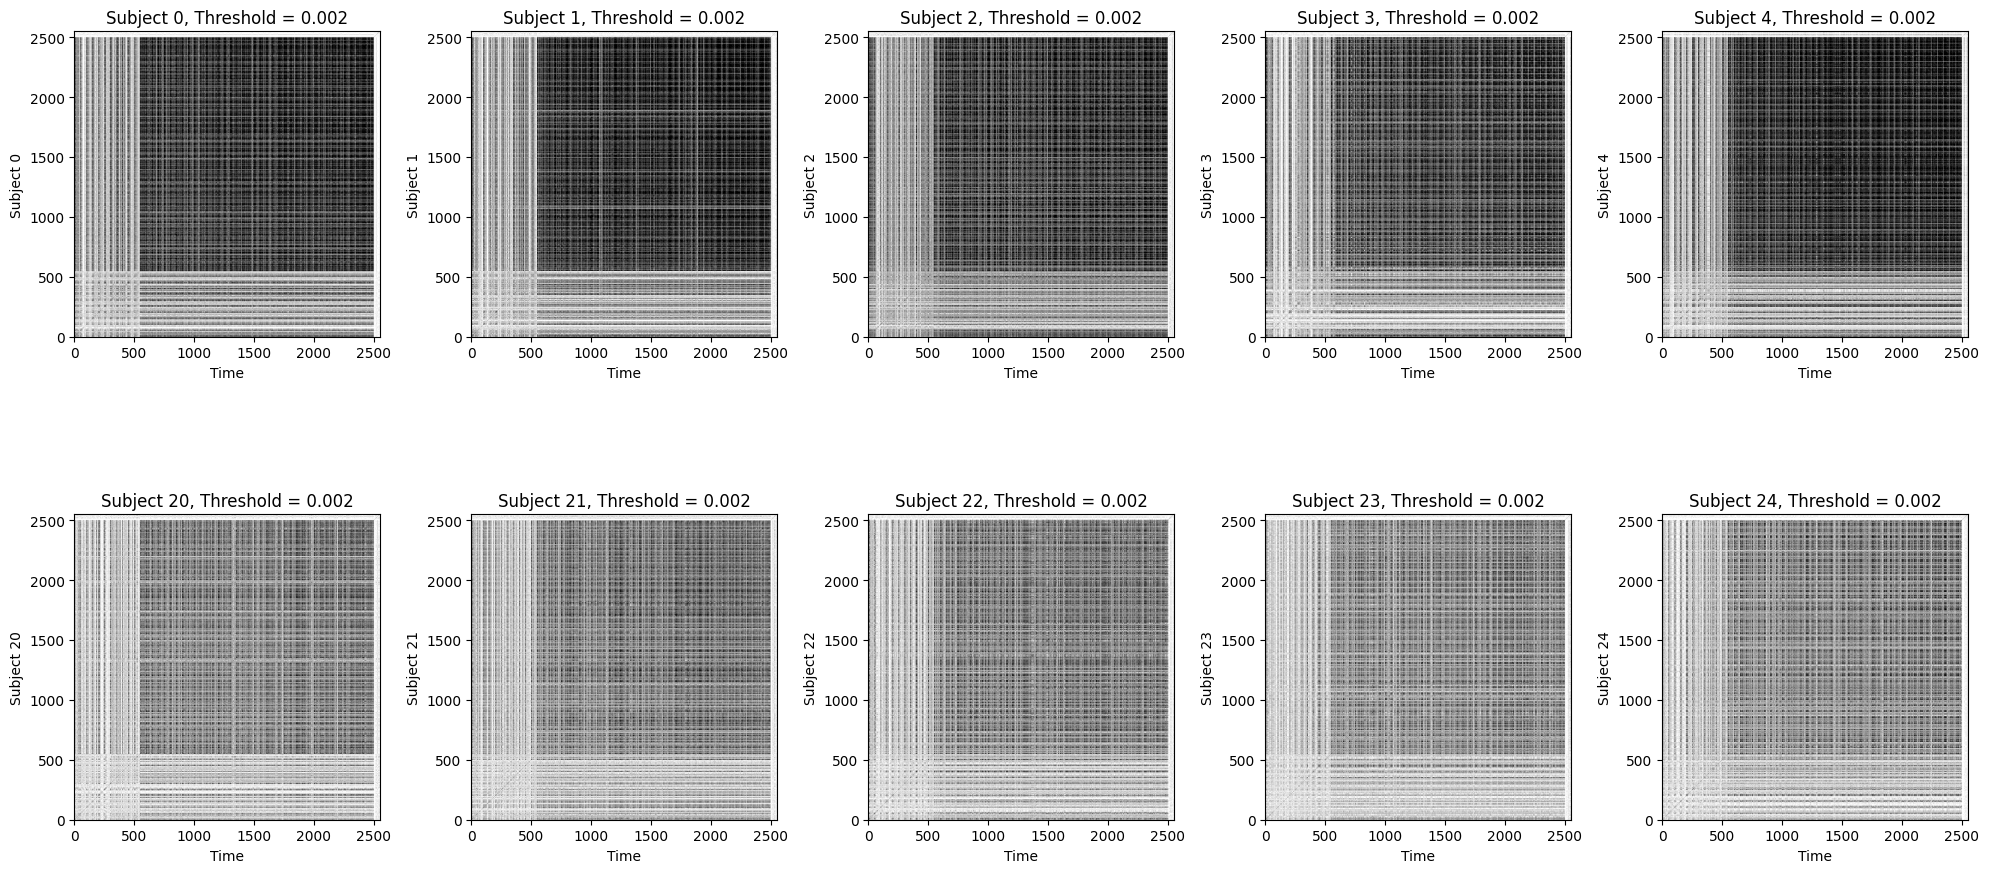

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pyunicorn.timeseries.recurrence_plot import RecurrencePlot


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.preprocessing import MinMaxScaler
from pyts.image import RecurrencePlot as Recu

def plot_recurrence_for_subjects(data, thresholds=[0.1, 0.2, 0.3]):
    """
    Genera y visualiza una gráfica recurrente para cada sujeto en el dataset.

    :param data: numpy array de forma (n_sujetos, n_features), donde n_sujetos es el número de sujetos
                 y n_features es la representación interna del RC para cada sujeto.
    :param thresholds: lista de valores de umbral para la recurrencia.
    """
    n_subjects = data.shape[0]

    for subject_index in range(n_subjects):
        # Obtener los datos para el sujeto actual
        subject_data = data[subject_index]

        # Normalizar los datos del sujeto
        #subject_data_normalized = (subject_data - np.mean(subject_data)) / np.std(subject_data)

        for threshold in thresholds:
            # Creación de la gráfica recurrente con el umbral especificado
            rp = RecurrencePlot(subject_data.reshape(-1, 1), threshold=threshold)

            # Obtener la matriz de recurrencia
            recurrence_matrix = rp.recurrence_matrix()

            # Verificación de la matriz de recurrencia
            if np.sum(recurrence_matrix) == 0:
                print(f'La matriz de recurrencia para el sujeto {subject_index} con umbral {threshold} está vacía.')
                continue

            # Visualización de la gráfica recurrente
            plt.figure()
            plt.imshow(recurrence_matrix, cmap='binary', origin='lower')
            plt.xlabel('Time')
            plt.ylabel('Time')
            plt.title(f'Recurrence Plot for Subject {subject_index} with Threshold {threshold}')
            plt.show()

def plot_recurrence_for_subjects_group(data, young_subjects, old_subjects, thresholds=[0.1, 0.2, 0.3]):
    """
    Genera y visualiza matrices de recurrencia para sujetos jóvenes y mayores.

    Parameters:
    data (numpy.ndarray): Datos de representación de los sujetos.
    young_subjects (list): Índices de los sujetos jóvenes.
    old_subjects (list): Índices de los sujetos mayores.
    thresholds (list): Lista de valores de umbral para la recurrencia.
    """
    n_young = len(young_subjects)
    n_old = len(old_subjects)
    n_thresholds = len(thresholds)

    # Calcular número total de subplots necesarios
    n_plots = max(n_young, n_old) * n_thresholds

    # Crear la figura con subplots adecuados
    fig, axes = plt.subplots(nrows=2, ncols=max(n_young, n_old) * n_thresholds, figsize=(20, 10))

    # Iterar sobre los umbrales
    for j, threshold in enumerate(thresholds):
        # Iterar sobre los sujetos jóvenes
        for i, subject_index in enumerate(young_subjects):
            # Determinar el índice correcto del subplot
            subplot_index = i * n_thresholds + j
            ax = axes[0, subplot_index]

            # Obtener datos del sujeto y normalizarlos
            subject_data = data[subject_index]
            subject_data_normalized = MinMaxScaler().fit_transform(subject_data.reshape(-1, 1)).flatten()

            # Crear plot de matriz de recurrencia
            rp = Recu (threshold=threshold)
            recurrence_matrix = rp.fit_transform(subject_data_normalized.reshape(1, -1))[0]

            # Mostrar matriz de recurrencia en el subplot correspondiente
            ax.imshow(recurrence_matrix, cmap='binary', origin='lower')
            ax.set_xlabel('Time')
            ax.set_ylabel(f'Subject {subject_index}')
            ax.set_title(f'Subject {subject_index}, Threshold = {threshold}')

        # Iterar sobre los sujetos mayores
        for k, subject_index in enumerate(old_subjects):
            # Determinar el índice correcto del subplot
            subplot_index = k * n_thresholds + j
            ax = axes[1, subplot_index]

            # Obtener datos del sujeto y normalizarlos
            subject_data = data[subject_index]
            subject_data_normalized = MinMaxScaler().fit_transform(subject_data.reshape(-1, 1)).flatten()

            # Crear plot de matriz de recurrencia
            rp = Recu (threshold=threshold)
            recurrence_matrix = rp.fit_transform(subject_data_normalized.reshape(1, -1))[0]

            # Mostrar matriz de recurrencia en el subplot correspondiente
            ax.imshow(recurrence_matrix, cmap='binary', origin='lower')
            ax.set_xlabel('Time')
            ax.set_ylabel(f'Subject {subject_index}')
            ax.set_title(f'Subject {subject_index}, Threshold = {threshold}')

    plt.tight_layout()
    plt.show()
# Ejemplo de uso con datos aleatorios (reemplaza esto con tus datos reales)
mts_rep_reshaped = rc_dim_states_o.reshape(rc_dim_states_o.shape[0], rc_dim_states_o.shape[1], -1)
print (mts_rep_reshaped.shape)
young_subjects = [0, 1, 2, 3, 4 ]  # Example indices, replace with your actual indices
old_subjects = [20, 21, 22, 23, 24  ]   # Example indices, replace with your actual indices

plot_recurrence_for_subjects_group(input_repr_o, young_subjects, old_subjects, thresholds=[0.002]) #, 0.2, 0.3


In [18]:
import numpy as np

def calculate_potential_memory(mts_representations, tolerance = 0.05):
    """
    Calculate the potential memory for given multivariate time series representations.

    Parameters:
    mts_representations (numpy.ndarray): The multivariate time series representations.
    tolerance (float): The tolerance threshold to consider the memory potential. Default is 0.05.

    Returns:
    list: A list containing the potential memory for each representation.
    """
    potential_memory = []

    for representation in mts_representations:
        y_initial = representation[0]

        for t, y_t in enumerate(representation[1:], start=1):
            if np.linalg.norm(y_t - y_initial) < tolerance:
                potential_memory.append(t)
                break
    return potential_memory
#################################
mts_representations = rc_dim_states_o.reshape(rc_dim_states_o.shape[0], rc_dim_states_o.shape[1], -1)
mts_representations = input_repr_o
print("Dimensiones de mts_representations:", mts_representations.shape)

# Verifica los primeros elementos de mts_representations para asegurarte de que estás seleccionando adecuadamente
print("Primeras representaciones de mts_representations:")
for i, rep in enumerate(mts_representations[:2]):
    print(f"\t\t Representación {i}: Shape {rep.shape}")
# Calculate the potential memory for young adult subjects
potential_memory_young_adults = calculate_potential_memory (mts_representations [:20])
# Calculate the potential memory for older subjects
potential_memory_older_adults = calculate_potential_memory (mts_representations [20:])

# Imprimir los resultados
print("Memoria potencial para sujetos jóvenes adultos:", potential_memory_young_adults)
print("Memoria potencial para sujetos mayores:", potential_memory_older_adults)

Dimensiones de mts_representations: (40, 2550)
Primeras representaciones de mts_representations:
		 Representación 0: Shape (2550,)
		 Representación 1: Shape (2550,)
Memoria potencial para sujetos jóvenes adultos: [714, 255, 153, 459, 1377, 561, 714, 561, 867, 714, 612, 561, 663, 612, 2295, 561, 1428, 561, 816, 612]
Memoria potencial para sujetos mayores: [561, 561, 561, 102, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 612, 561, 561, 561, 561, 408]


# ***Métodos NO SUPERVISADOS***

# ***T-SNE***

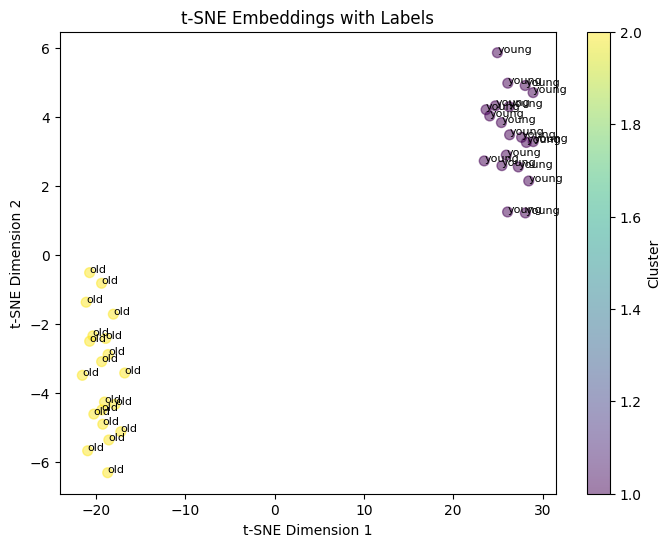

In [19]:
from sklearn.manifold import TSNE

def plot_tsne_with_labels(data, clusters, labels):
    """
    Realiza la reducción de dimensionalidad con t-SNE y grafica el scatter plot con las etiquetas.

    Args:
    - data (numpy.ndarray): Los datos de entrada.
    - clusters (numpy.ndarray): Las etiquetas de los clústeres.
    - labels (list): Las etiquetas correspondientes a los datos.
    - label_map (dict): Un mapeo de índices de datos a posiciones t-SNE.

    Returns:
    None
    """
    # Reducción de dimensionalidad con t-SNE
    tsne = TSNE (n_components = 2, perplexity = 10, random_state = 0)
    embeddings_tsne = tsne.fit_transform (data)

    # Graficar el scatter plot con las etiquetas
    plt.figure (figsize = (8, 6))
    plt.scatter (embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.5)
    n_subjects = embeddings_tsne.shape [0]
    for idx in range (n_subjects):
        plt.text(embeddings_tsne[idx, 0], embeddings_tsne[idx, 1], labels [idx], fontsize=8)

    plt.title('t-SNE Embeddings with Labels')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.colorbar(label='Cluster')
    plt.show()
mts_representations_o = input_repr_o
# Llamar a la función con las etiquetas de los puntos y el mapeo
plot_tsne_with_labels(mts_representations_o, clust, words_labels)

# *Cálculo del coeficiente de silhouette:*

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


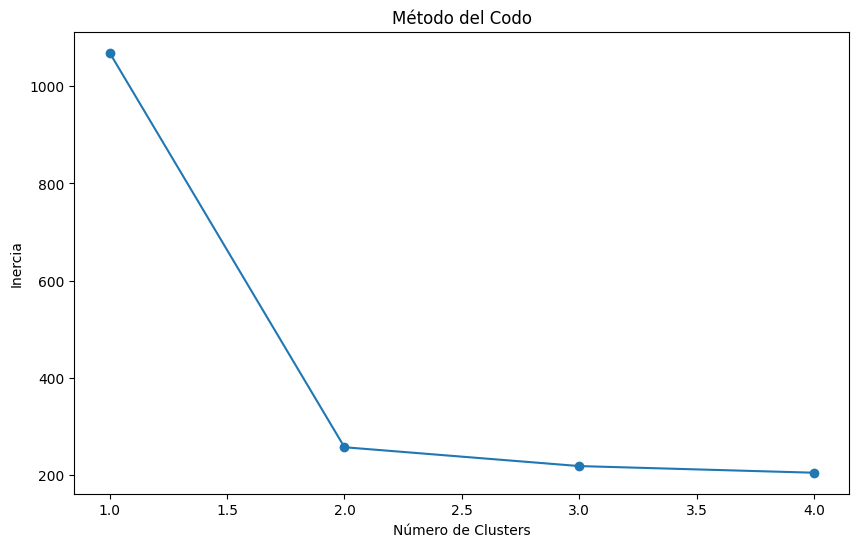

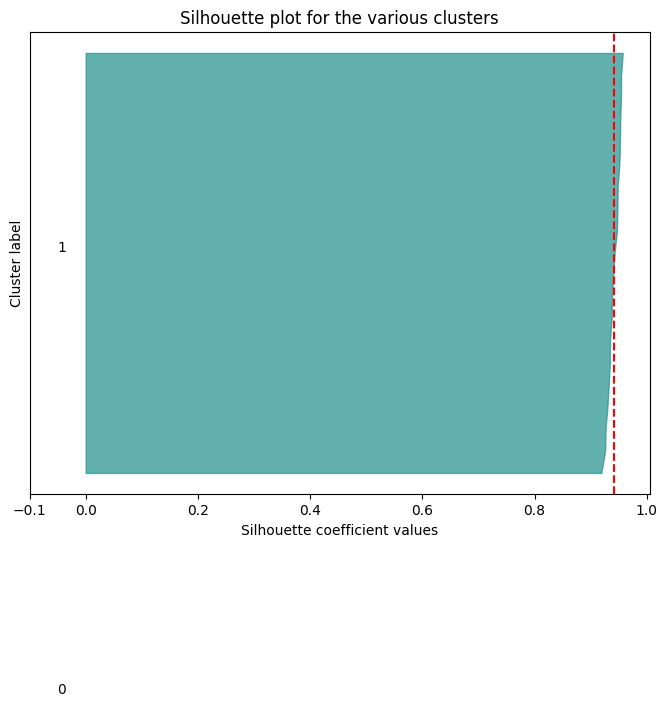

Coeficiente de Silhouette promedio: 0.9411783


0.9411783

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE

def create_one_hot_labels (n_samples, n_clusters):
    """
    Crea etiquetas one-hot en función del número de clústeres.

    Args:
    - n_samples (int): El número total de muestras.
    - n_clusters (int): El número de clústeres.

    Returns:
    - labels (numpy.ndarray): Las etiquetas one-hot.
    """

    labels = np.zeros((n_samples, n_clusters), dtype=int)
    for i in range(n_samples):
        cluster_index = np.random.randint(0, n_clusters)  # Elegir aleatoriamente un clúster para cada muestra
        labels[i, cluster_index] = 1  # Establecer la etiqueta one-hot correspondiente al clúster seleccionado

    return labels
def encode(labels_one_hot):
    """
    Convierte las etiquetas codificadas en one-hot al formato 0-1.

    Args:
    - labels_one_hot (numpy.ndarray): Las etiquetas codificadas en one-hot.

    Returns:
    - labels (numpy.ndarray): Las etiquetas en el formato 0-1.
    """
    return np.argmax(labels_one_hot, axis=1)
def calculate_silhouette_score(data, clust,  n_components=2):
    """
    Calcula el coeficiente de silhouette para un conjunto de datos y grafica el coeficiente de silhouette para cada punto agrupado por los clusters.

    Args:
    - data (numpy.ndarray): Los datos de entrada.

    Returns:
    - silhouette_avg (float): El coeficiente de silhouette promedio para todos los puntos.
    """

    # Reducción de dimensionalidad con t-SNE
    tsne = TSNE (n_components = n_components, perplexity = 10, random_state = 0)
    embeddings_tsne = tsne.fit_transform (data)

    # Calcular el número óptimo de clusters usando K-means o cualquier otro algoritmo de clustering
    n_clusters = find_optimal_clusters (data = data, max_k = 4)

    #  asignación de clústeres con jerarquico

    n_samples = data.shape[0]

    clust = clust

    # Calcular el coeficiente de silhouette para cada punto
    silhouette_values = silhouette_samples(embeddings_tsne, clust)

    # Calcular el coeficiente de silhouette promedio para todos los puntos
    silhouette_avg = silhouette_score(embeddings_tsne, clust)

    # Graficar el coeficiente de silhouette
    plt.figure(figsize=(8, 6))
    # Crear una barra horizontal para cada punto
    y_lower = 10
    for i in range(n_clusters):
        # Agregar el coeficiente de silhouette para los puntos en el cluster i
        cluster_silhouette_values = silhouette_values[clust == i]
        cluster_silhouette_values.sort()
        size_cluster_i = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.viridis(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Etiquetar el cluster i en el gráfico
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Calcular el siguiente y_lower para el próximo cluster
        y_lower = y_upper + 10

    plt.title("Silhouette plot for the various clusters")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")  # Línea vertical para el promedio del coeficiente de silhouette
    plt.yticks([])  # Quitar las etiquetas del eje y
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

    print("Coeficiente de Silhouette promedio:", silhouette_avg)

    return silhouette_avg

#############

mts_representations_o = input_repr_o
calculate_silhouette_score (mts_representations_o, clust)

# ***Manifoolds***

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


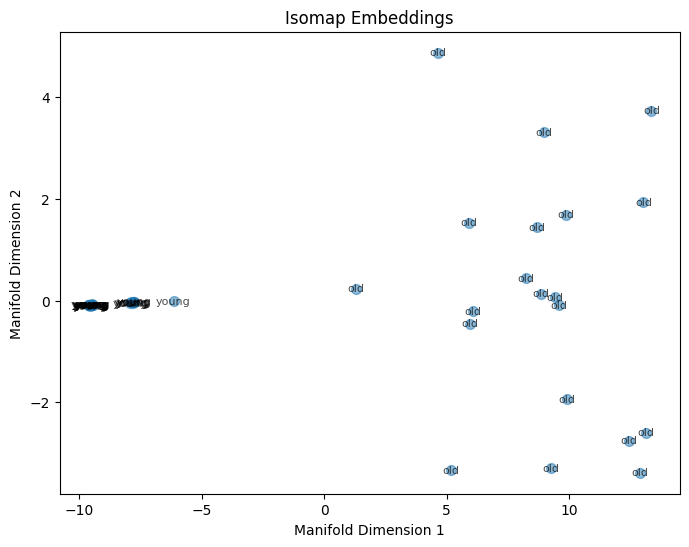

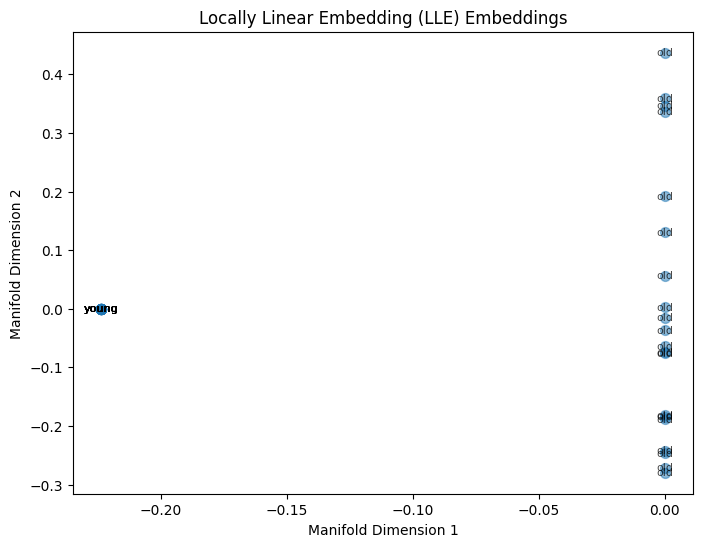

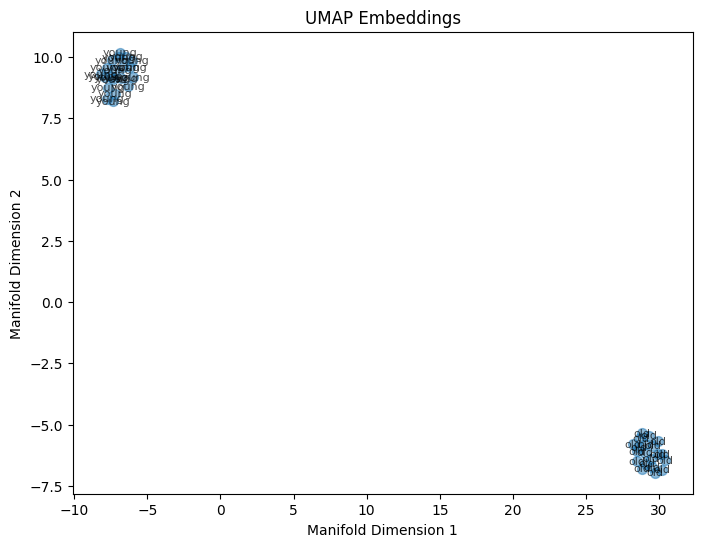

In [23]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding
from umap import UMAP
import matplotlib.pyplot as plt

# Función para visualizar los resultados de Manifold Learning con etiquetas
def plot_manifold_learning_with_labels_1 (embeddings, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], s=50, alpha=0.5)


    # Calcular el centro de los puntos para posicionar las etiquetas
    center_x = embeddings[:, 0].mean()
    center_y = embeddings[:, 1].mean()

    for i, word in enumerate(labels):
        # Calcular el desplazamiento de la etiqueta
        x_offset = embeddings[i, 0] - center_x
        y_offset = embeddings[i, 1] - center_y

        # Posicionar la etiqueta cerca del punto correspondiente
        plt.text(embeddings[i, 0], embeddings[i, 1], word, fontsize=8,
                 horizontalalignment='center', verticalalignment='center',
                 color='black', alpha=0.7, rotation=0,
                 transform=plt.gca().transData)

    plt.title(title)
    plt.xlabel('Manifold Dimension 1')
    plt.ylabel('Manifold Dimension 2')
    plt.show()
# Función para visualizar los resultados de Manifold Learning con etiquetas
def plot_manifold_learning_with_labels (embeddings, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], s=50, alpha=0.5)

    n_subjects = embeddings.shape [0]
    for i in range (n_subjects):
        # Posicionar la etiqueta cerca del punto correspondiente
        plt.text(embeddings[i, 0], embeddings[i, 1], labels [i], fontsize=8,
                 horizontalalignment='center', verticalalignment='center',
                 color='black', alpha=0.7, rotation=0,
                 transform=plt.gca().transData)

    plt.title(title)
    plt.xlabel('Manifold Dimension 1')
    plt.ylabel('Manifold Dimension 2')
    plt.show()

# Crear un diccionario que mapee índices de datos a posiciones de embeddings
label_map = {idx: idx for idx in range(len(mts_representations_o))}

##########################
mts_representations_o = input_repr_o
# Aplicar Isomap
isomap = Isomap(n_components = 2)
embeddings_isomap = isomap.fit_transform (mts_representations_o)
# Llamar a la función con las etiquetas de los puntos y las proyecciones de Isomap
plot_manifold_learning_with_labels (embeddings_isomap, words_labels, 'Isomap Embeddings')


# Aplicar Locally Linear Embedding (LLE)
lle = LocallyLinearEmbedding (n_components = 2)
embeddings_lle = lle.fit_transform (mts_representations_o)
# Llamar a la función con las etiquetas de los puntos y las proyecciones de LLE
plot_manifold_learning_with_labels (embeddings_lle, words_labels, 'Locally Linear Embedding (LLE) Embeddings')


# Aplicar Uniform Manifold Approximation and Projection (UMAP)
umap = UMAP (n_components = 2)
embeddings_umap = umap.fit_transform (mts_representations_o)
# Llamar a la función con las etiquetas de los puntos y las proyecciones de UMAP
plot_manifold_learning_with_labels (embeddings_umap, words_labels, 'UMAP Embeddings')

# Comprobamos la reconstrucción de los canales y medimos la coherencia de las señales


La coherencia en el contexto del EEG se refiere a la medida de la sincronización o relación lineal entre las señales de dos canales diferentes en un mismo EEG. Esta medida puede ayudar a entender cómo están relacionadas las actividades neuronales entre distintas regiones del cerebro.

# Recosntruimos las señales

In [24]:
from sklearn.linear_model import Ridge

# Inicializar un diccionario para almacenar los modelos de regresión por canal y sujeto
ridge_models_tr = {}
ridge_models_pr = {}

mts_repesent = rc_state_o


n_all_sample  = mts_repesent.shape [1]
size_RC       = mts_repesent.shape [2]

n_subject     = X.shape [0]
n_samples     = X.shape [1]
n_channels    = X.shape [2]

X_orig = Xo
# Si bidireccional, duplicar y concatenar los datos de entrada
if config_clus_o ['bidir']:
    Xo_b = Xo [:, ::-1, :].copy()
    X_orig = np.concatenate((Xo, Xo_b), axis=1)
    n_samples = X_orig.shape[1]

# Entrenar un modelo de regresión Ridge para cada canal y sujeto
for subject in range(n_subject):
    #print (f'* subject:{subject}')
    ridge_models_tr [subject] = {}  # Diccionario para modelos de entrenamiento
    ridge_models_pr [subject] = {}  # Diccionario para modelos de predicción
    for canal in range (n_channels):
        # print (f'* canal:{canal}')
        ridge_model_tr = Ridge(alpha = 1.0)                # Ajusta el parámetro alpha según sea necesario
        X_r = mts_repesent [subject].reshape (-1, size_RC)        # Las características son la representación RC aplanada
        y_r = X_orig [subject, :, canal].reshape (-1)   # La etiqueta es la señal para el canal actual
        # print (X.size())
        # print (y.size())
        ridge_model_tr.fit (X_r, y_r)
        ridge_models_tr [subject][canal] = ridge_model_tr


# Recosntruimos las señales
# Hacer predicciones para cada canal y sujeto
rec_subject_channel  = {}
for subject in range(n_subject):
    #print (f'* subject:{subject}')
    rec_subject_channel[subject]  = {}
    for canal in range(n_channels):
        model_s_c_tr  = ridge_models_tr [subject][canal]
        rec_subject_channel [subject][canal]  = model_s_c_tr.predict(mts_repesent [subject]).reshape (n_samples)
    #print (f'* canal:{canal}')

# Convertimos el diccionario en un array tridimensional [numero sujetos, numero muestras señal, nñumero canales]
rep_eeg = np.array([[[value for value in channel] for channel in subject.values()] for subject in rec_subject_channel.values()])
print (rep_eeg.shape)


(40, 10, 4000)


In [25]:

# Convertimos el diccionario en un array tridimensional
rep_eeg = np.array([[[value for value in channel] for channel in subject.values()] for subject in rec_subject_channel.values()])
print (rep_eeg.shape)


(40, 10, 4000)


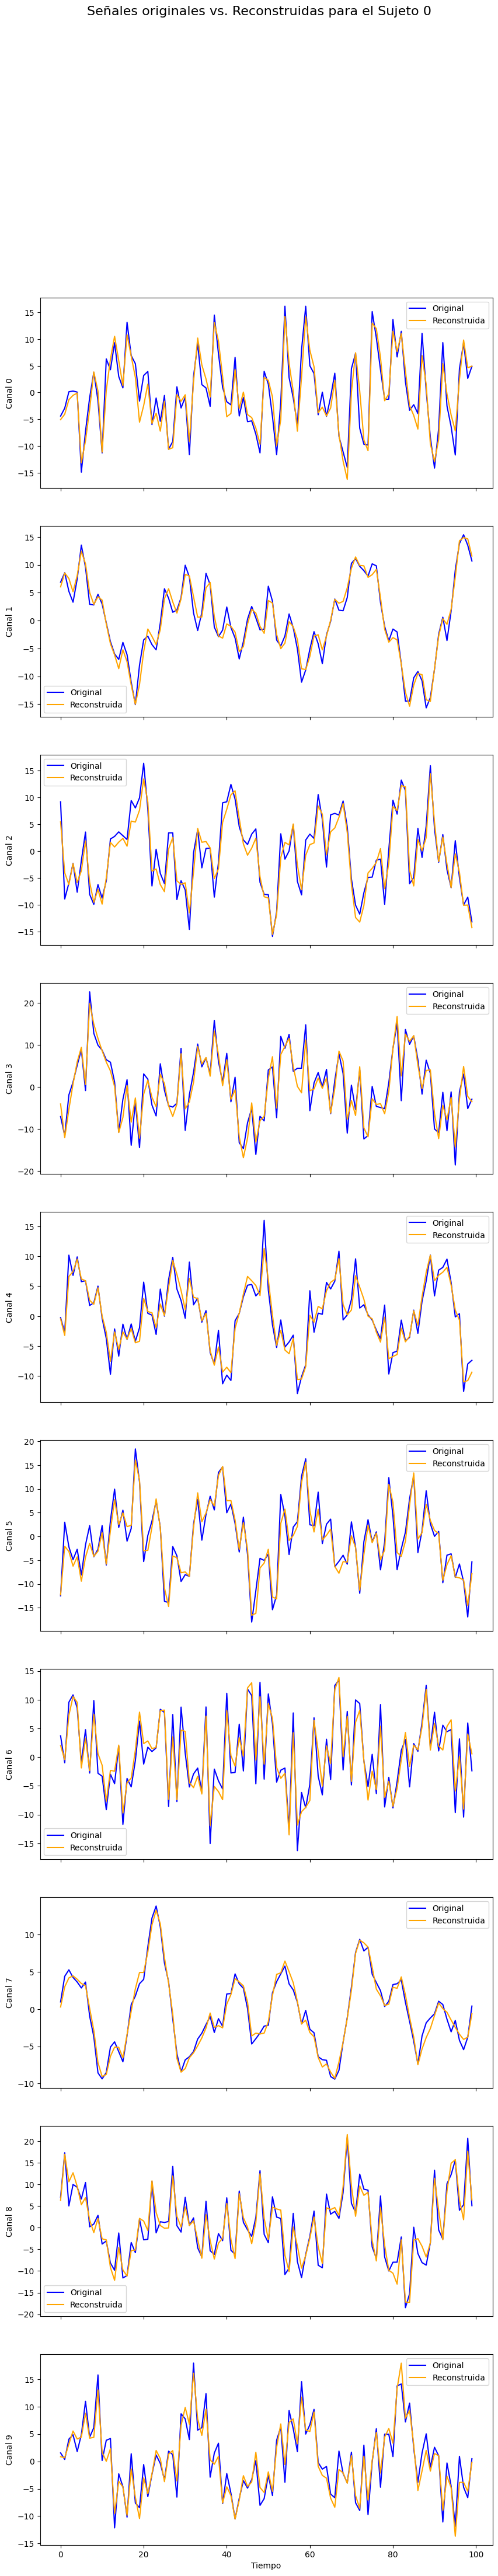

In [26]:
import matplotlib.pyplot as plt

def plot_signals_original_vs_reconstructed(original_signals, reconstructed_signals):


    fig, axs = plt.subplots(n_channels, 1, figsize=(10, 5*n_channels), sharex=True)
    fig.suptitle(f'Señales originales vs. Reconstruidas para el Sujeto {subject_index}', fontsize=16)

    for i in range(n_channels):
        original_signal      = original_signals [:100, i]
        rec_signal = reconstructed_signals[i, :100]

        axs[i].plot(original_signal, label='Original', color='blue')
        axs[i].plot(rec_signal, label='Reconstruida', color='orange')
        axs[i].set_ylabel(f'Canal {i}')
        axs[i].legend()

    plt.xlabel('Tiempo')
    plt.show()

#################
subject_index = 0
eeg_o = Xo [subject_index]
eeg_r = rep_eeg [subject_index]
plot_signals_original_vs_reconstructed (eeg_o,eeg_r )

# Calculamos la coherencia para las señales reconstruidas..

config_clus_o ['bidir']:True
eeg_o.shape: (4000, 10)
eeg_o: (10, 4000)
eeg_r: (10, 4000)
Cxy average for channel 0: 0.6056094329945786
Cxy shape: (129,)
f shape: (129,)


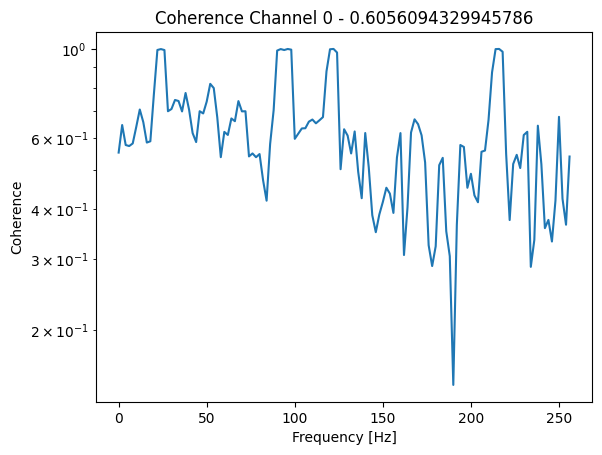

Cxy average for channel 1: 0.7416337738044773
Cxy shape: (129,)
f shape: (129,)


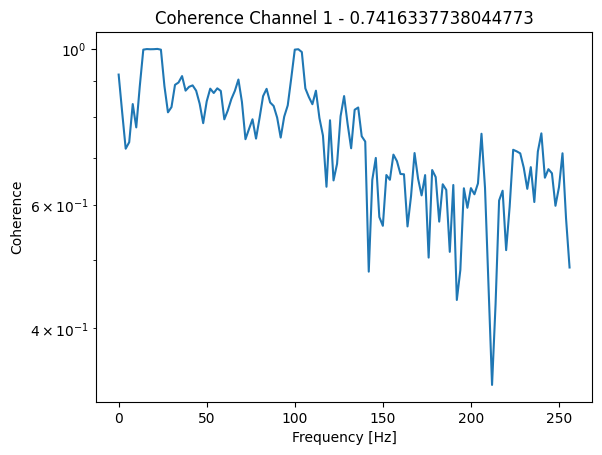

Cxy average for channel 2: 0.6376459075275713
Cxy shape: (129,)
f shape: (129,)


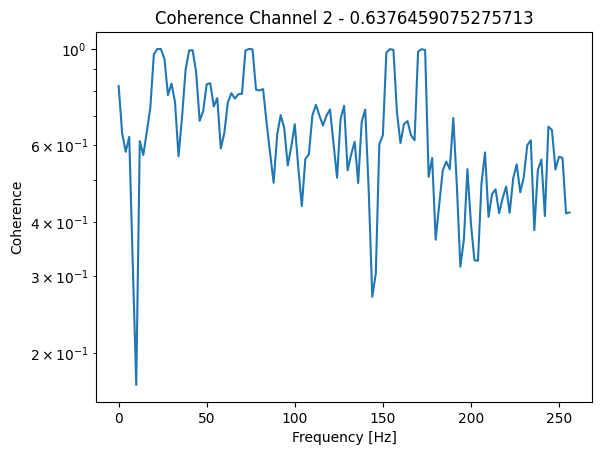

Cxy average for channel 3: 0.6369142662818141
Cxy shape: (129,)
f shape: (129,)


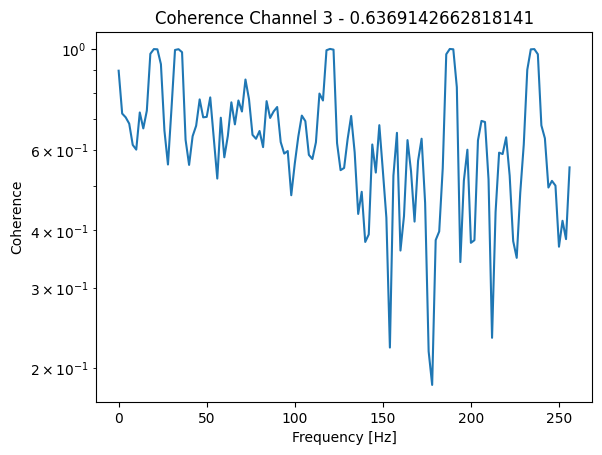

Cxy average for channel 4: 0.7348105306702911
Cxy shape: (129,)
f shape: (129,)


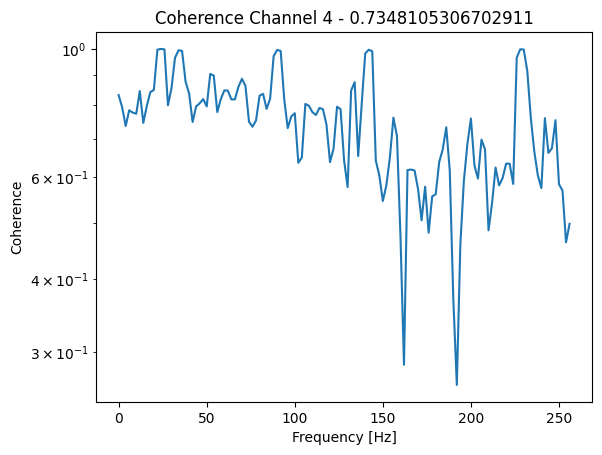

Cxy average for channel 5: 0.654611567209632
Cxy shape: (129,)
f shape: (129,)


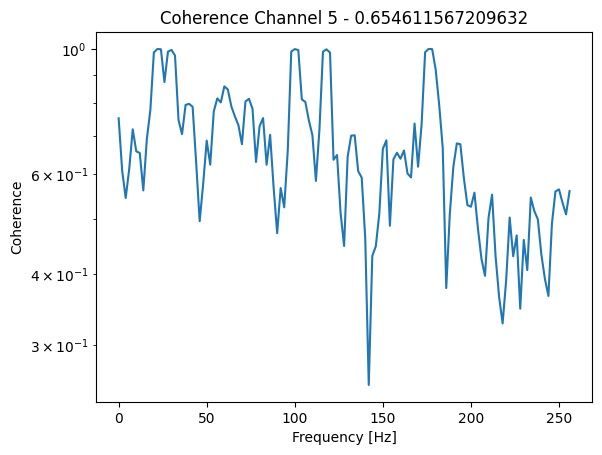

Cxy average for channel 6: 0.6269936656262943
Cxy shape: (129,)
f shape: (129,)


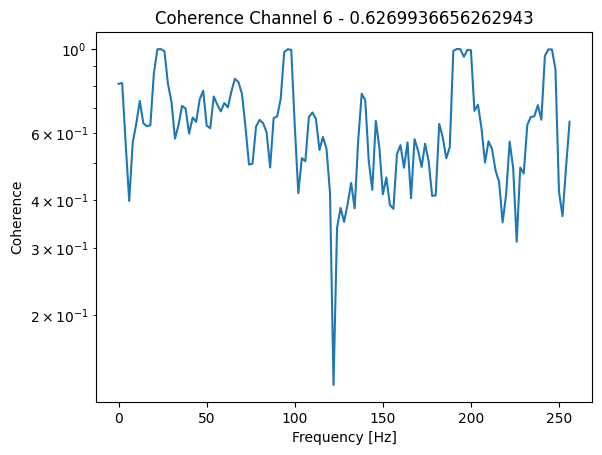

Cxy average for channel 7: 0.7922341854118338
Cxy shape: (129,)
f shape: (129,)


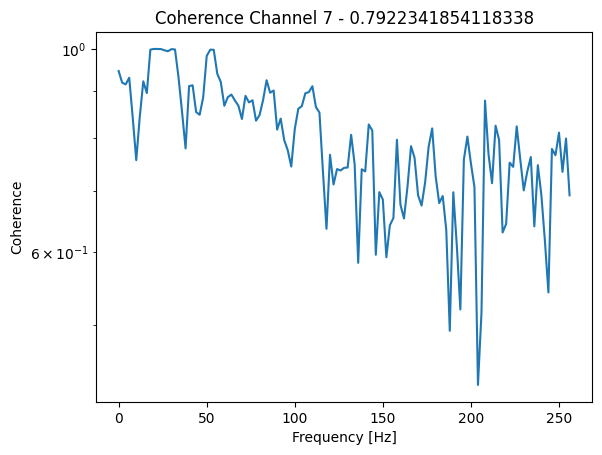

Cxy average for channel 8: 0.6164364408607638
Cxy shape: (129,)
f shape: (129,)


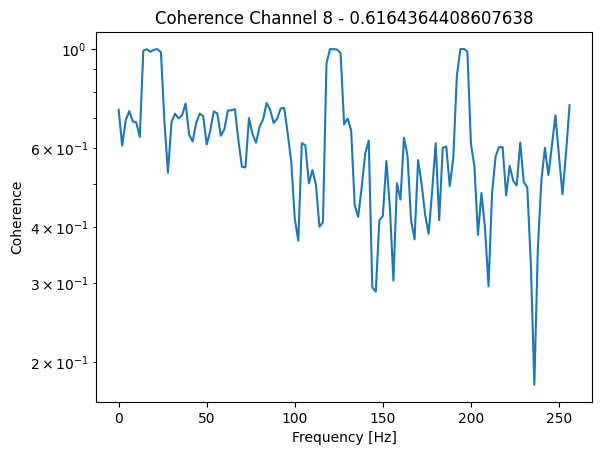

Cxy average for channel 9: 0.6809436220619307
Cxy shape: (129,)
f shape: (129,)


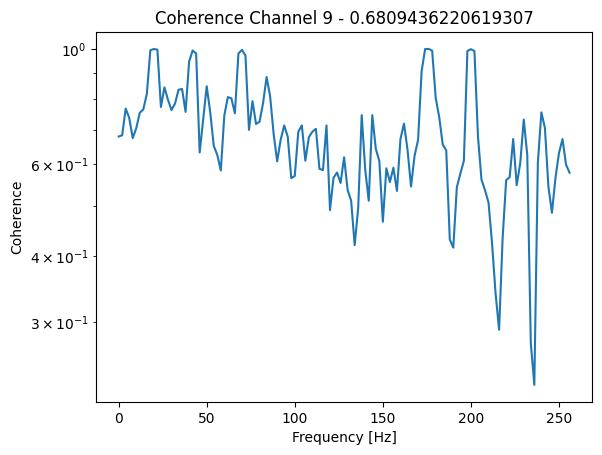

Coherencia promedio entre todos los canales: 0.6727833392449188


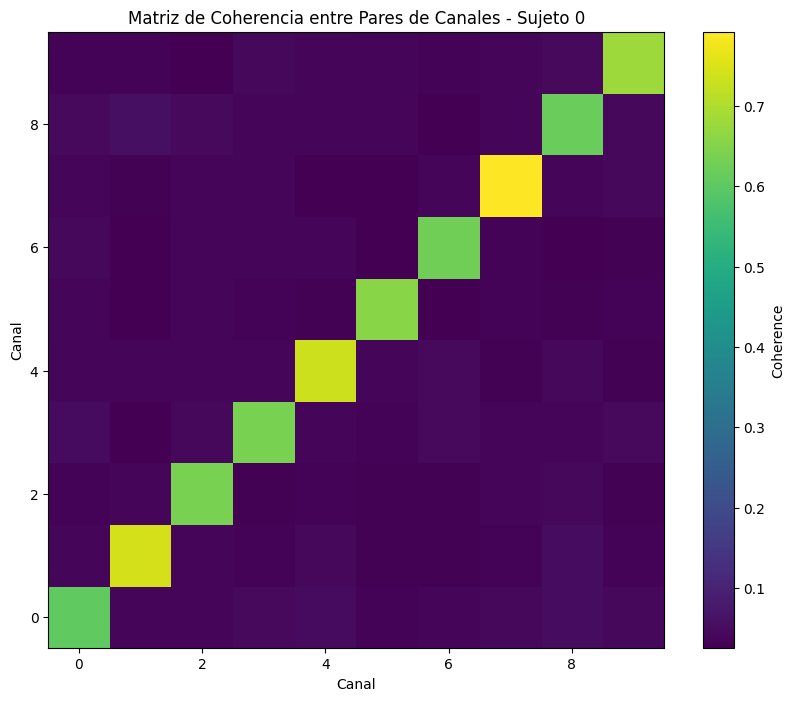

In [ ]:
import numpy as np
from scipy.signal import coherence
import matplotlib.pyplot as plt
from base.eeg import create_coherence_matrix, create_coherence_original_vs_reconstructed
# Definir bandas de frecuencia
bandas_frecuencia = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 100)
}


# Si bidireccional, duplicar y concatenar los datos de entrada
print(f"config_clus_o ['bidir']:{config_clus_o['bidir']}")
X_orig = Xo
if config_clus_o['bidir']:
    Xo_b = Xo[:, ::-1, :].copy()
    X_orig = np.concatenate((Xo, Xo_b), axis=1)
    n_samples = X_orig.shape[1]

subject_index = 0
eeg_o = X_orig[subject_index]
print(f'eeg_o.shape: {eeg_o.shape}')

# Intercambio de valores
eeg_o = eeg_o.T
eeg_r = rep_eeg[subject_index]

# Calcular la coherencia para el sujeto en una banda específica (por ejemplo, Alpha)
banda = bandas_frecuencia['Alpha']
coherence_subject,coherence_subject_band = create_coherence_original_vs_reconstructed(eeg_o, eeg_r, banda=banda)

# Calcular la coherencia promedio
average_coherence = np.mean(coherence_subject)
print("Coherencia promedio entre todos los canales:", average_coherence)

# Crear la matriz de coherencia
coherence_matrix = create_coherence_matrix(eeg_o, eeg_r)

# Graficar el mapa de calor (heatmap) de la matriz de coherencia
plt.figure(figsize=(10, 8))
plt.imshow(coherence_matrix, cmap='viridis', origin='lower')
plt.colorbar(label='Coherence')
plt.title(f'Matriz de Coherencia entre Pares de Canales - Sujeto {subject_index}')
plt.xlabel('Canal')
plt.ylabel('Canal')
plt.grid(False)
plt.show()


# Información mutua entre canales originales y recosntruidos para cada sujeto

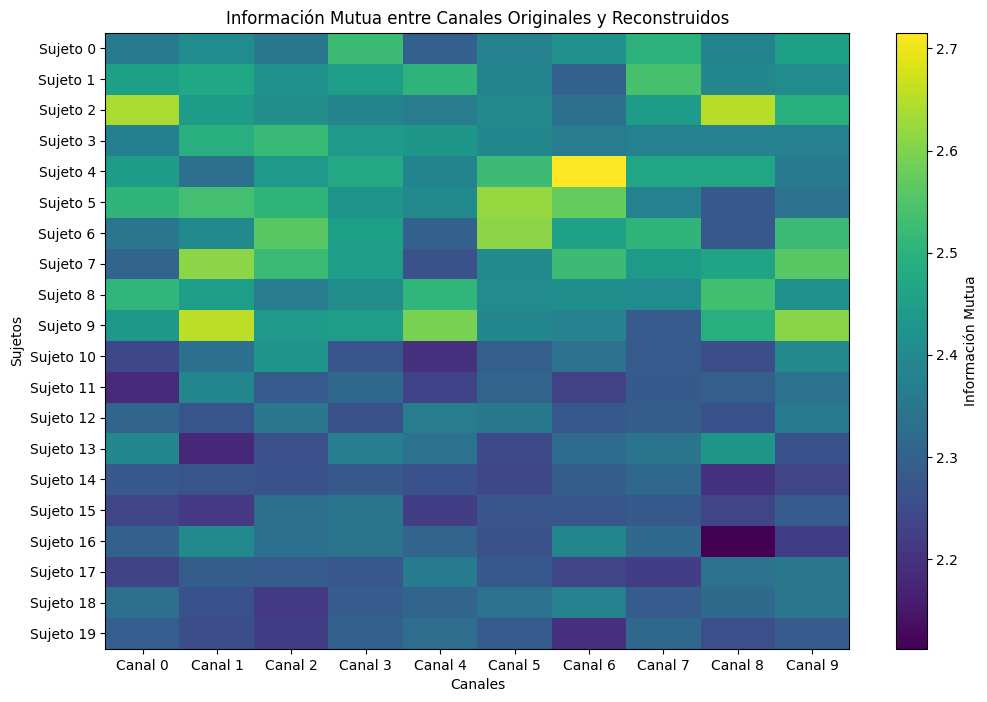

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def mutual_information(original_signals, reconstructed_signals):
    mutual_info_values = []
    for i in range(original_signals.shape[1]):
        # Calcula las histogramas conjuntos y marginales para el par de canales actual
        joint_hist, _, _ = np.histogram2d(original_signals[:, i], reconstructed_signals[:, i], bins=20)
        pxy = joint_hist / np.sum(joint_hist)
        px = np.sum(pxy, axis=1)
        py = np.sum(pxy, axis=0)

        # Calcula la información mutua para el par de canales actual
        Hxy = -np.sum(pxy * np.log2(pxy + (pxy == 0)))
        Hx = -np.sum(px * np.log2(px + (px == 0)))
        Hy = -np.sum(py * np.log2(py + (py == 0)))
        mutual_info = Hx + Hy - Hxy
        mutual_info_values.append(mutual_info)
    return mutual_info_values

def plot_mutual_info_heatmap(mutual_info_matrix, channel_labels=None, subject_labels=None):
    """
    Crea un mapa de calor para visualizar la información mutua entre canales originales y reconstruidos para cada sujeto.

    Args:
    - mutual_info_matrix (numpy.ndarray): Matriz de información mutua. Debe tener la forma (n_subjects, n_channels).
    - channel_labels (list): Lista de etiquetas para los canales. Debe tener longitud n_channels.
    - subject_labels (list): Lista de etiquetas para los sujetos. Debe tener longitud n_subjects.

    Returns:
    - None
    """
    n_subjects, n_channels = mutual_info_matrix.shape

    # Definir etiquetas para los ejes x e y si no se proporcionan
    if channel_labels is None:
        channel_labels = [f'Canal {i}' for i in range(n_channels)]
    if subject_labels is None:
        subject_labels = [f'Sujeto {i}' for i in range(n_subjects)]

    # Crear el mapa de calor
    plt.figure(figsize=(12, 8))
    plt.imshow(mutual_info_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Información Mutua')
    plt.title('Información Mutua entre Canales Originales y Reconstruidos')
    plt.xlabel('Canales')
    plt.ylabel('Sujetos')
    plt.xticks(np.arange(n_channels), channel_labels)
    plt.yticks(np.arange(n_subjects), subject_labels)
    plt.show()

# IM para los canales originales y reconstruidos
fs = 512  # Frecuencia de muestreo (solo necesario para el cálculo del error de fase)

n_subjects = Xo.shape [0]
X_orig = Xo
if config_clus_o['bidir']:
    Xo_b = Xo[:, ::-1, :].copy()
    X_orig = np.concatenate((Xo, Xo_b), axis=1)
    n_samples = X_orig.shape[1]
# Matriz para almacenar los valores de información mutua para cada sujeto y canal
mutual_info_matrix = np.zeros((n_subjects, n_channels))
for idx_subject in range (n_subjects):
    EEG_O = X_orig [idx_subject]
    EEG_R = rep_eeg [idx_subject]
    EEG_R = np.array (np.swapaxes(EEG_R, 0, 1))
    mutual_info_matrix [idx_subject] = mutual_information(EEG_O, EEG_R)

n_channels = EEG_O.shape [1]  # Número de canales
plot_mutual_info_heatmap(mutual_info_matrix)

La verdad que la IM no me da ninguna información porque no tengo una mediada de referencia que me indique la bondad de la recosntrucción. No se si el hecho de que todos sean myores a 1.4 es bueno o no...--123--

# Error de fase entre canales originales y recosntruidos para cada sujeto

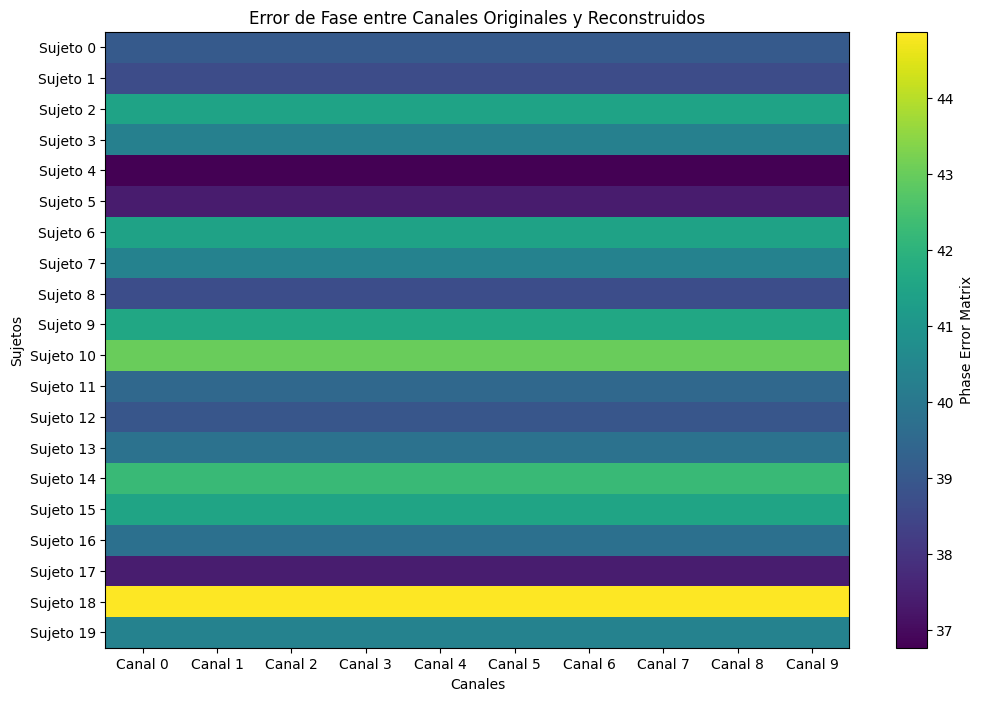

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def phase_error(original_signal, reconstructed_signal, fs):
    # Calcula la FFT de las señales
    fft_original = np.fft.fft(original_signal)
    fft_reconstructed = np.fft.fft(reconstructed_signal)

    # Calcula la diferencia de fase
    phase_original = np.angle(fft_original)
    phase_reconstructed = np.angle(fft_reconstructed)
    phase_diff = phase_original - phase_reconstructed

    # Convierte la diferencia de fase a radianes y calcula el error medio
    phase_diff_radians = np.unwrap(phase_diff)
    phase_error = np.abs(phase_diff_radians) * (180 / np.pi)  # Convertir a grados
    mean_phase_error = np.mean(phase_error)
    return mean_phase_error



def plot_phase_error_heatmap (phase_error_matrix, channel_labels = None, subject_labels = None):
    """
    Crea un mapa de calor para visualizar la información mutua entre canales originales y reconstruidos para cada sujeto.

    Args:
    - phase_error_matrix (numpy.ndarray): Matriz de error de fase. Debe tener la forma (n_subjects, n_channels).
    - channel_labels (list): Lista de etiquetas para los canales. Debe tener longitud n_channels.
    - subject_labels (list): Lista de etiquetas para los sujetos. Debe tener longitud n_subjects.

    Returns:
    - None
    """
    n_subjects, n_channels = mutual_info_matrix.shape

    # Definir etiquetas para los ejes x e y si no se proporcionan
    if channel_labels is None:
        channel_labels = [f'Canal {i}' for i in range(n_channels)]
    if subject_labels is None:
        subject_labels = [f'Sujeto {i}' for i in range(n_subjects)]

    # Crear el mapa de calor
    plt.figure(figsize=(12, 8))
    plt.imshow(phase_error_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Phase Error Matrix')
    plt.title('Error de Fase entre Canales Originales y Reconstruidos')
    plt.xlabel('Canales')
    plt.ylabel('Sujetos')
    plt.xticks(np.arange(n_channels), channel_labels)
    plt.yticks(np.arange(n_subjects), subject_labels)
    plt.show()

# IM para los canales originales y reconstruidos
sr = 512  # Frecuencia de muestreo (solo necesario para el cálculo del error de fase)

n_subjects = Xo.shape [0]
X_orig = Xo
if config_clus_o['bidir']:
    Xo_b = Xo[:, ::-1, :].copy()
    X_orig = np.concatenate((Xo, Xo_b), axis=1)
    n_samples = X_orig.shape[1]
# Matriz para almacenar los valores de phase error para cada sujeto y canal
phase_error_matrix = np.zeros((n_subjects, n_channels))
for idx_subject in range (n_subjects):
    EEG_O = X_orig [idx_subject]
    EEG_R = rep_eeg [idx_subject]
    EEG_R = np.array (np.swapaxes(EEG_R, 0, 1))
    phase_error_matrix [idx_subject] = phase_error (EEG_O, EEG_R, sr)

n_channels = EEG_O.shape [1]  # Número de canales
plot_phase_error_heatmap (phase_error_matrix)

In [ ]:


def mean_squared_error(original_signal, reconstructed_signal):
    mse = np.mean((original_signal - reconstructed_signal) ** 2)
    return mse

def mean_absolute_error(original_signal, reconstructed_signal):
    mae = np.mean(np.abs(original_signal - reconstructed_signal))
    return mae

In [ ]:
n_subjects = Xo.shape [0]
X_orig = Xo
if config_clus_o['bidir']:
    Xo_b = Xo[:, ::-1, :].copy()
    X_orig = np.concatenate((Xo, Xo_b), axis=1)
    n_samples = X_orig.shape[1]
# Matriz para almacenar los valores de phase error para cada sujeto y canal
phase_error_matrix = np.zeros((n_subjects, n_channels))
for idx_subject in range (n_subjects):
    print("* Subject:", idx_subject)
    EEG_O = X_orig [idx_subject]
    EEG_R = rep_eeg [idx_subject]
    EEG_R = np.array (np.swapaxes (EEG_R, 0, 1))

    mse_value = mean_squared_error (EEG_O, EEG_R)
    mae_value = mean_absolute_error (EEG_O, EEG_R)

    print("\t\t - Mean Squared Error (MSE):", mse_value)
    print("\t\t - Mean Absolute Error (MAE):", mae_value)


* Subject: 0
		 - Mean Squared Error (MSE): 3.475912386228508
		 - Mean Absolute Error (MAE): 1.462052157556605
* Subject: 1
		 - Mean Squared Error (MSE): 3.4513578633930346
		 - Mean Absolute Error (MAE): 1.4900595845265048
* Subject: 2
		 - Mean Squared Error (MSE): 3.262356819052212
		 - Mean Absolute Error (MAE): 1.4400159165140614
* Subject: 3
		 - Mean Squared Error (MSE): 3.366584140959641
		 - Mean Absolute Error (MAE): 1.4736949636442895
* Subject: 4
		 - Mean Squared Error (MSE): 2.6444687818900507
		 - Mean Absolute Error (MAE): 1.2920334940040377
* Subject: 5
		 - Mean Squared Error (MSE): 3.8039846640510127
		 - Mean Absolute Error (MAE): 1.5544144874101993
* Subject: 6
		 - Mean Squared Error (MSE): 3.551389526047329
		 - Mean Absolute Error (MAE): 1.5059223314669077
* Subject: 7
		 - Mean Squared Error (MSE): 3.414877627300254
		 - Mean Absolute Error (MAE): 1.4607264834714309
* Subject: 8
		 - Mean Squared Error (MSE): 3.968414264900397
		 - Mean Absolute Error (MAE): 


# ***Supervisado*** con *READOUT* para calsificación: lin, mlp. svr, ovr

In [ ]:
################
### GENERAMOS DATOS SINTETICOS
################
# Ejemplo datos sinteticos CON autorregresivo
n_subjects_per_group  = 10
n_samples_per_subject = 1000
n_channels            = 10
sr                    = 512  # frecuencia de muestreo

synthetic_data_auto, labels_auto = generate_synthetic_eeg_data(n_subjects_per_group, n_samples_per_subject, n_channels, sr)

print("Dimensiones de los datos sintéticos con autoregresivo:", synthetic_data_auto.shape)
print("Dimensiones de las etiquetas de los autoregresivos:", labels_auto.shape)


Dimensiones de los datos sintéticos con autoregresivo: (20, 1000, 10)
Dimensiones de las etiquetas de los autoregresivos: (20, 2)


In [5]:
# Dividir los sujetos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(synthetic_data_auto, labels_auto, test_size=0.4, random_state=42)

print ("Dimensiones de los datos de entrenamiento:", X_train.shape)
print ("Dimensiones de las etiquetas de entrenamiento:", y_train.shape)
print("Dimensiones de los datos de prueba:", X_test.shape)
print("Dimensiones de las etiquetas de prueba:", y_test.shape)

Dimensiones de los datos de entrenamiento: (24, 2000, 10)
Dimensiones de las etiquetas de entrenamiento: (24, 2)
Dimensiones de los datos de prueba: (16, 2000, 10)
Dimensiones de las etiquetas de prueba: (16, 2)


# ***Reaout:lin***



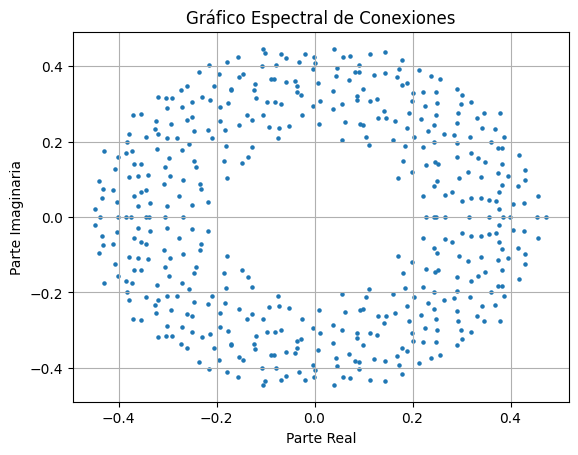

In [6]:
# config_clas
# config_clas
config_clas = {
    'seed': 1,
    'init_type':'orthogonal',
    'init_std':0.01,
    'init_mean':0,
    'input_size':10,
    'input_scaling':0.1,
    'n_drop': None,
    'washout':'init',
    'use_input_bias':True,
    'use_input_layer':True,
    'bidir': True,
    'dimred_method': 'tenpca',
    'n_dim': 50,
    'mts_rep':'reservoir',
    'w_ridge_embedding':1.0,
    'readout_type': 'lin',
    'threshold':0.5,
    'svm_kernel': 'linear',
    'svm_gamma': 0.005,
    'svm_C': 5.0,
    'w_ridge': 5.0,
    'num_epochs': 2000,
    'mlp_layout': (10, 10),
    'w_l2': 0.001,
    'n_internal_units': 480,
    'spectral_radius': 0.59,
    'leak': 0.4,
    'nonlinearity':'relu', # 'relu','tanh'
    'connectivity': 0.6,
    'noise_level': 0.1,
    'circle': False,
    'plasticity_synaptic':None,
    'theta_m':0.01,
    'plasticity_intrinsic':None,
    'learning_rate':0.9,
    'new_activation_function':'tanh',
    'excitability_factor':0.01,
    'device': 'cpu'
}


model_esn_clas = MyESN (config_clas)

# Llamar al método para trazar el gráfico espectral
model_esn_clas.plot_spectral_graph ()

In [7]:
# Instanciar un objeto MyRC
my_rc = MyRC(model_esn_clas, config_clas)

# Entrenar el modelo
# result_rc  = my_rc_clus_o.fit (X)
# Devolvemos: Estados internos neuronas, Etados internos reducidos a PCA, Representación estados internos, Readout
# rc_state, rc_dim_states, input_repr, output_redout_layer = result_rc
result_rc  = my_rc.fit (X_train, y_train)
rc_state, rc_dim_states, input_repr, output_redout_layer = result_rc
print (f'output_redout_layer:{rc_state.shape}')

output_redout_layer:(24, 4000, 480)


fit_evaluate :Yte: [[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
fit_evaluate :mts_rep_state_xte: (16, 4000, 480)
fit_evaluate :n_tr_drop: None
fit_evaluate :lin :fit_evaluate :self.readout_type : lin
fit_evaluate :lin :logits : [[ 8.3279967e-01  1.6720033e-01]
 [ 1.1609894e+00 -1.6098917e-01]
 [ 1.1605655e+00 -1.6056538e-01]
 [ 5.9095025e-04  9.9940920e-01]
 [ 6.8696380e-01  3.1303632e-01]
 [ 9.3025947e-01  6.9740534e-02]
 [-1.9233674e-02  1.0192337e+00]
 [-2.4490952e-03  1.0024492e+00]
 [-1.7215848e-02  1.0172160e+00]
 [ 9.6659768e-01  3.3402562e-02]
 [-2.5583804e-03  1.0025585e+00]
 [ 1.0293653e+00 -2.9365301e-02]
 [ 9.1037369e-01  8.9626312e-02]
 [ 4.2141676e-03  9.9578595e-01]
 [ 4.3412745e-03  9.9565881e-01]
 [ 1.2490679e+00 -2.4906790e-01]]
fit_evaluate :lin :pred_class : [[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]

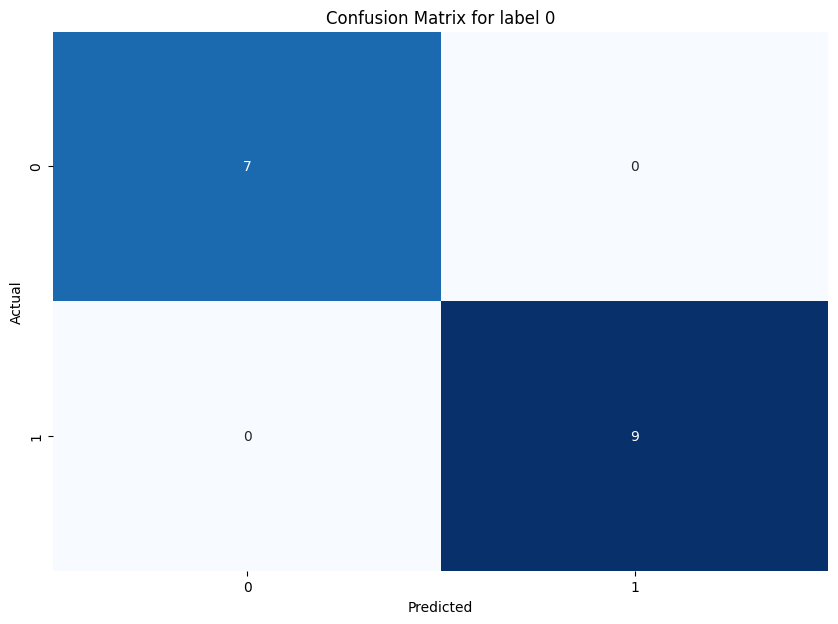

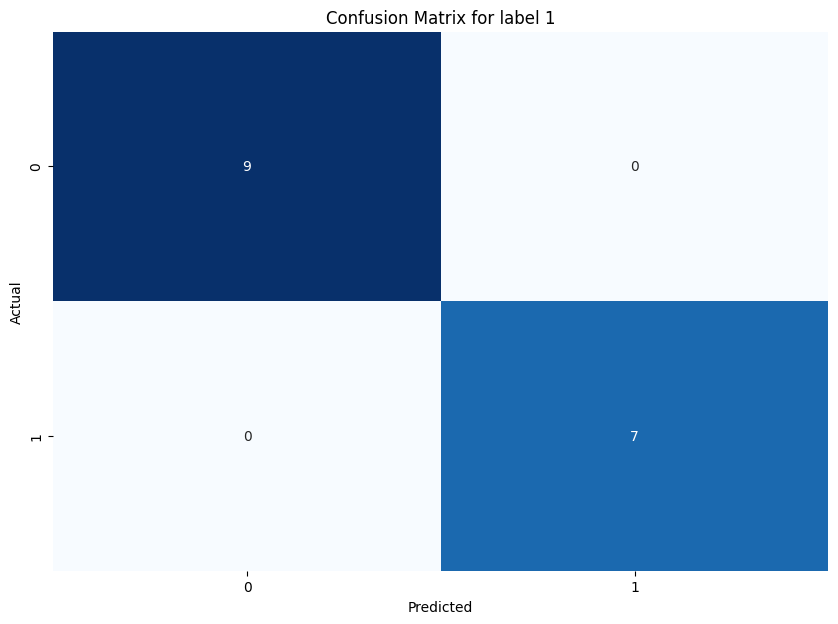

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         7

   micro avg       1.00      1.00      1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16
 samples avg       1.00      1.00      1.00        16

* report :               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         7

   micro avg       1.00      1.00      1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16
 samples avg       1.00      1.00      1.00        16

 ************** FIN CLASIFICACION  ************************************


In [8]:
#EValuar el modelo
report = my_rc.fit_evaluate (X_test, y_test)
##
print ('* report :', report)
print (f' ************** FIN CLASIFICACION  ************************************')

# ***Reaout:mlp***

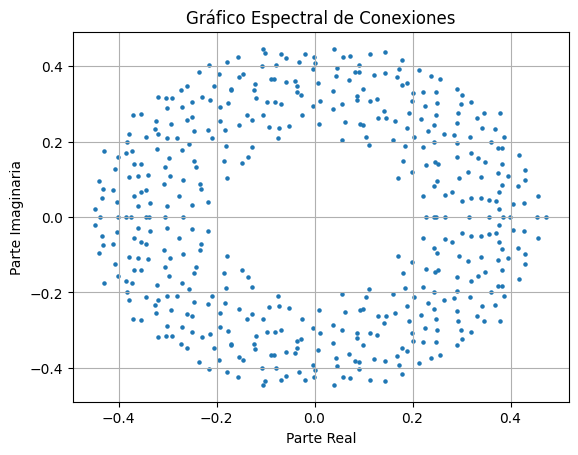

In [21]:
# config_clas
config_clas = {
    'seed': 1,
    'init_type':'orthogonal',
    'init_std':0.01,
    'init_mean':0,
    'input_size':10,
    'input_scaling':0.1,
    'n_drop': None,
    'washout':'init',
    'use_input_bias':True,
    'use_input_layer':True,
    'bidir': False,
    'dimred_method': 'tenpca',
    'n_dim': 44,
    'mts_rep':'reservoir',
    'w_ridge_embedding':1.0,
    'readout_type': 'mlp',
    'threshold':0.5,
    'svm_kernel': 'linear',
    'svm_gamma': 0.005,
    'svm_C': 5.0,
    'w_ridge': 5.0,
    'num_epochs': 4000,
    'mlp_layout': (100, 100),
    'mlp_batch_size':32,
    'mlp_learning_rate':0.01,
    'mlp_learning_rate_type':'constant', # 'constant' or 'adaptive'
    'w_l2': 0.01,
    'n_internal_units': 480,
    'spectral_radius': 0.59,
    'leak': 0.4,
    'nonlinearity':'relu', # 'relu','tanh'
    'connectivity': 0.6,
    'noise_level': 0.1,
    'circle': False,
    'plasticity_synaptic':None,
    'theta_m':0.01,
    'plasticity_intrinsic':None,
    'learning_rate':0.9,
    'new_activation_function':'tanh',
    'excitability_factor':0.01,
    'device': 'cpu'
}

model_esn_clas = MyESN (config_clas)

# Llamar al método para trazar el gráfico espectral
model_esn_clas.plot_spectral_graph ()

In [22]:
# Instanciar un objeto MyRC
my_rc = MyRC(model_esn_clas, config_clas)

# result_rc  = my_rc_clus_o.fit (X)
# Devolvemos: Estados internos neuronas, Etados internos reducidos a PCA, Representación estados internos, Readout
# rc_state, rc_dim_states, input_repr, output_redout_layer = result_rc
result_rc  = my_rc.fit (X_train, y_train)
rc_state, rc_dim_states, input_repr, output_redout_layer = result_rc
print (f'output_redout_layer:{rc_state.shape}')

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


output_redout_layer:torch.Size([24, 2000, 480])


fit_evaluate :Yte: [[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
fit_evaluate :mts_rep_state_xte: torch.Size([16, 2000, 480])
fit_evaluate :n_tr_drop: None
fit_evaluate :lin :fit_evaluate :self.readout_type : mlp
fit_evaluate :mlp :pred_prob : [[0.6280632  0.35968217]
 [0.6124078  0.3872711 ]
 [0.68849593 0.24699348]
 [0.4184894  0.56070644]
 [0.5773083  0.41325912]
 [0.6601421  0.35479775]
 [0.4171814  0.5604592 ]
 [0.4076071  0.55655485]
 [0.42578325 0.55496526]
 [0.606992   0.3720277 ]
 [0.38744682 0.56928444]
 [0.6780137  0.3423173 ]
 [0.5839929  0.39727885]
 [0.39921188 0.5715815 ]
 [0.42498168 0.5604116 ]
 [0.6430313  0.3981004 ]]
fit_evaluate :mlp :pred_class_max : [0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 0]
fit_evaluate :mlp :pred_class : [[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]]
fit_evaluate :Yte : [[1 0]
 [1 0]
 [1 0]


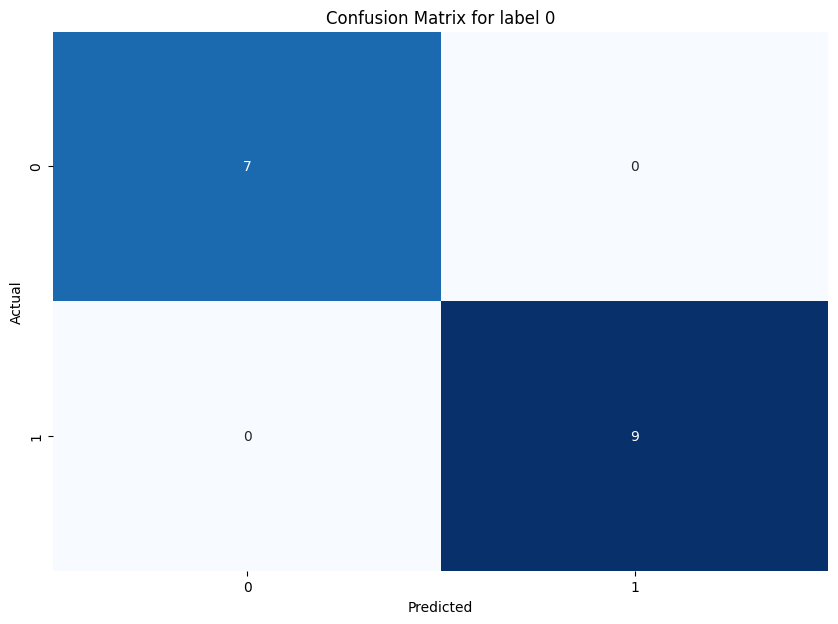

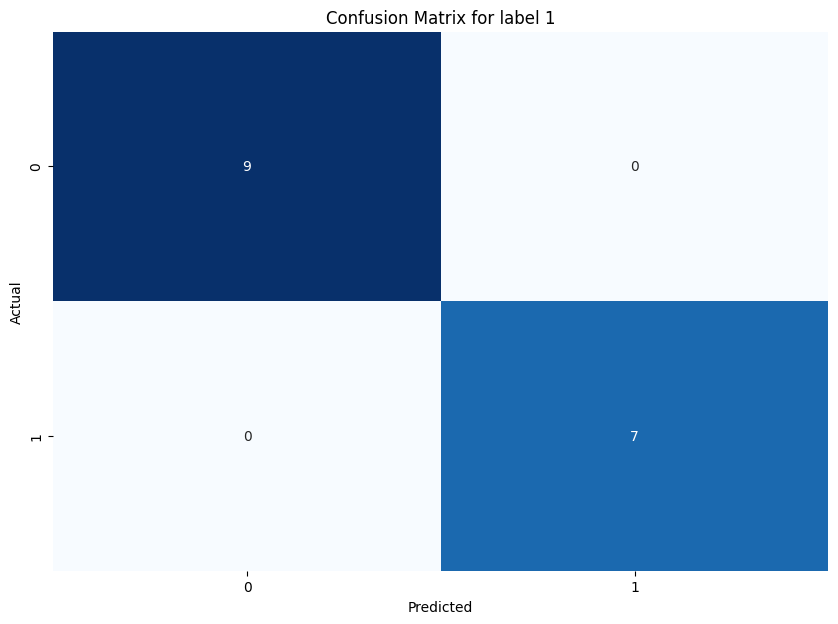

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         7

   micro avg       1.00      1.00      1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16
 samples avg       1.00      1.00      1.00        16

* report :               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         7

   micro avg       1.00      1.00      1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16
 samples avg       1.00      1.00      1.00        16

 ************** FIN CLASIFICACION  ************************************


In [23]:
#EValuar el modelo
report = my_rc.fit_evaluate (X_test, y_test)
##
print ('* report :', report)
print (f' ************** FIN CLASIFICACION  ************************************')

# ***Reaout:svm***

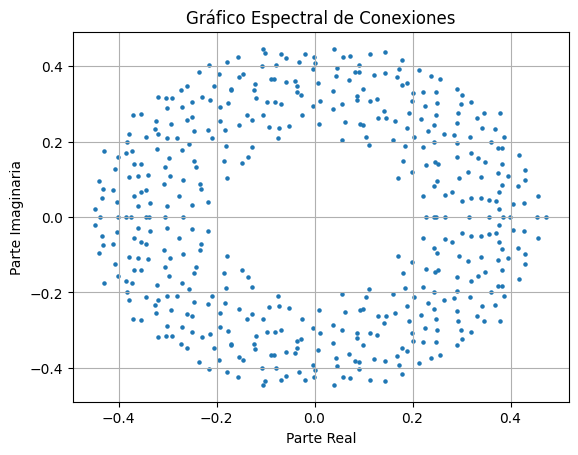

In [13]:
# config_clas
config_clas = {
         'seed': 1,
    'init_type':'orthogonal',
    'init_std':0.01,
    'init_mean':0,
    'input_size':10,
    'input_scaling':0.1,
    'n_drop': None,
    'washout':'init',
    'use_input_bias':True,
    'use_input_layer':True,
    'bidir': True,
    'dimred_method': 'tenpca',
    'n_dim': 50,
    'mts_rep':'reservoir',
    'w_ridge_embedding':1.0,
    'readout_type': 'svm',
    'threshold':0.5,
    'svm_kernel': 'linear',
    'svm_gamma': 0.005,
    'svm_C': 5.0,
    'w_ridge': 5.0,
    'num_epochs': 2000,
    'mlp_layout': (100, 100),
    'mlp_batch_size':32,
    'mlp_learning_rate':0.01,
    'mlp_learning_rate_type':'constant', # 'constant' or 'adaptive'
    'w_l2': 0.001,
    'n_internal_units': 480,
    'spectral_radius': 0.59,
    'leak': 0.4,
    'nonlinearity':'relu', # 'relu','tanh'
    'connectivity': 0.6,
    'noise_level': 0.1,
    'circle': False,
    'plasticity_synaptic':None,
    'theta_m':0.01,
    'plasticity_intrinsic':None,
    'learning_rate':0.9,
    'new_activation_function':'tanh',
    'excitability_factor':0.01,
    'device': 'cpu'
}
model_esn_clas = MyESN (config_clas)

# Llamar al método para trazar el gráfico espectral
model_esn_clas.plot_spectral_graph ()

In [14]:
# Instanciar un objeto MyRC
my_rc = MyRC(model_esn_clas, config_clas)

# result_rc  = my_rc_clus_o.fit (X)
# Devolvemos: Estados internos neuronas, Etados internos reducidos a PCA, Representación estados internos, Readout
# rc_state, rc_dim_states, input_repr, output_redout_layer = result_rc
result_rc  = my_rc.fit (X_train, y_train)
rc_state, rc_dim_states, input_repr, output_redout_layer = result_rc
print (f'output_redout_layer:{rc_state.shape}')

output_redout_layer:(24, 4000, 480)


fit_evaluate :Yte: [[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
fit_evaluate :mts_rep_state_xte: (16, 4000, 480)
fit_evaluate :n_tr_drop: None
fit_evaluate :lin :fit_evaluate :self.readout_type : svm
fit_evaluate _SVM:Yte : [[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]]
fit_evaluate _SVM:pred_class : [[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]]
fit_evaluate :Yte : [[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]]
fit_evaluate :pred_class : [[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]]
Multilabel Confusion Matrix:
[[[7 0]
  [0 9]]

 [[9 0]
  [0 7]]]


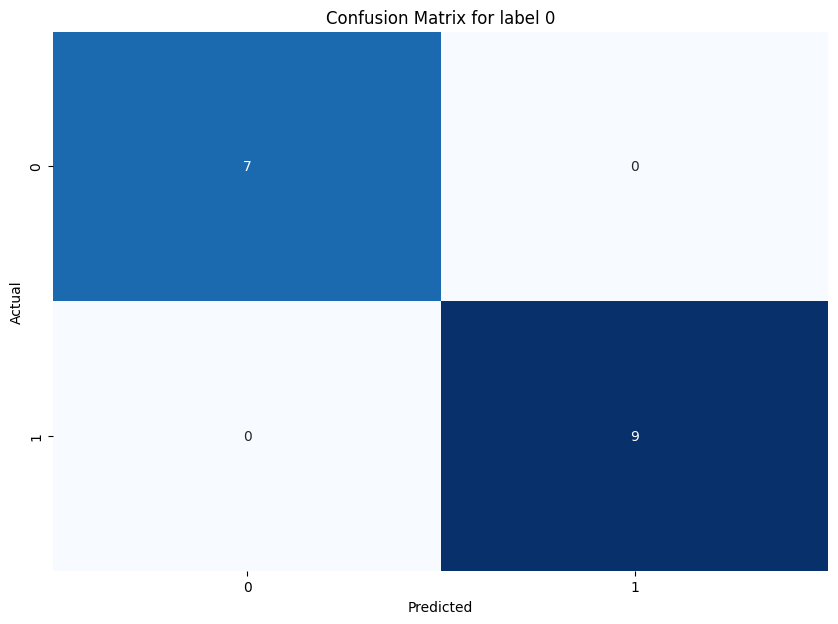

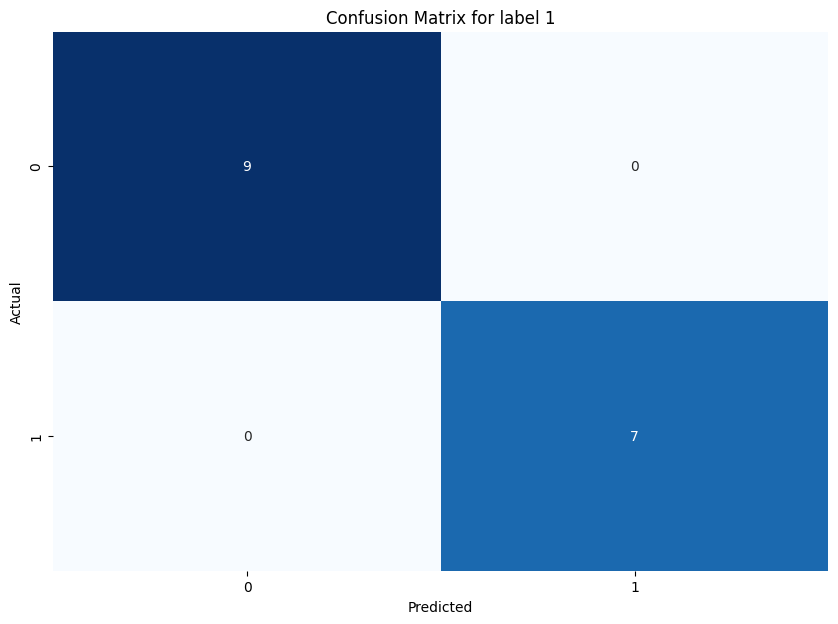

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         7

   micro avg       1.00      1.00      1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16
 samples avg       1.00      1.00      1.00        16

* report :               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         7

   micro avg       1.00      1.00      1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16
 samples avg       1.00      1.00      1.00        16

 ************** FIN CLASIFICACION  ************************************


In [15]:
#EValuar el modelo
report = my_rc.fit_evaluate (X_test, y_test)
##
print ('* report :', report)
print (f' ************** FIN CLASIFICACION  ************************************')

# ***Reaout:ovr***

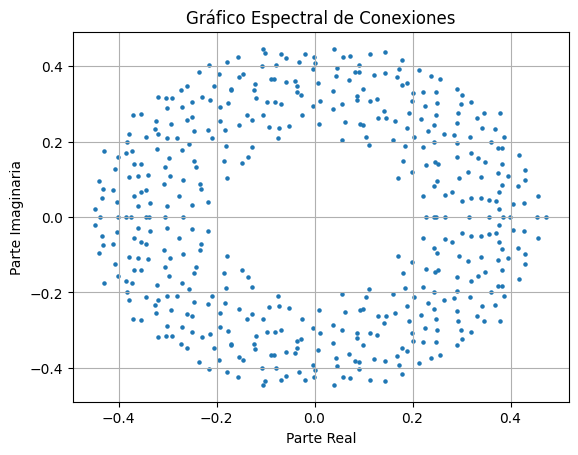

In [16]:
# config_clas
config_clas = {
    'seed': 1,
    'init_type':'orthogonal',
    'init_std':0.01,
    'init_mean':0,
    'input_size':10,
    'input_scaling':0.1,
    'n_drop': None,
    'washout':'init',
    'use_input_bias':True,
    'use_input_layer':True,
    'bidir': True,
    'dimred_method': 'tenpca',
    'n_dim': 50,
    'mts_rep':'reservoir',
    'w_ridge_embedding':1.0,
    'readout_type': 'ovr',
    'threshold':0.5,
    'svm_kernel': 'linear',
    'svm_gamma': 0.005,
    'svm_C': 5.0,
    'w_ridge': 5.0,
    'num_epochs': 2000,
    'mlp_layout': (100, 100),
    'mlp_batch_size':32,
    'mlp_learning_rate':0.01,
    'mlp_learning_rate_type':'constant', # 'constant' or 'adaptive'
    'w_l2': 0.001,
    'n_internal_units': 480,
    'spectral_radius': 0.59,
    'leak': 0.4,
    'nonlinearity':'relu', # 'relu','tanh'
    'connectivity': 0.6,
    'noise_level': 0.1,
    'circle': False,
    'plasticity_synaptic':None,
    'theta_m':0.01,
    'plasticity_intrinsic':None,
    'learning_rate':0.9,
    'new_activation_function':'tanh',
    'excitability_factor':0.01,
    'device': 'cpu'
}

model_esn_clas = MyESN (config_clas)

# Llamar al método para trazar el gráfico espectral
model_esn_clas.plot_spectral_graph ()

In [17]:
# Instanciar un objeto MyRC
my_rc = MyRC(model_esn_clas, config_clas)

# result_rc  = my_rc_clus_o.fit (X)
# Devolvemos: Estados internos neuronas, Etados internos reducidos a PCA, Representación estados internos, Readout
# rc_state, rc_dim_states, input_repr, output_redout_layer = result_rc
result_rc  = my_rc.fit (X_train, y_train)
rc_state, rc_dim_states, input_repr, output_redout_layer = result_rc
print (f'output_redout_layer:{rc_state.shape}')

output_redout_layer:(24, 4000, 480)


fit_evaluate :Yte: [[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
fit_evaluate :mts_rep_state_xte: (16, 4000, 480)
fit_evaluate :n_tr_drop: None
fit_evaluate :lin :fit_evaluate :self.readout_type : ovr
fit_evaluate :ovr :pred_prob : [[0.87351312 0.15251451]
 [0.9710633  0.03960636]
 [0.96834837 0.04319376]
 [0.07277901 0.92758814]
 [0.81130159 0.22013199]
 [0.93769967 0.07894437]
 [0.06054173 0.94166889]
 [0.06507662 0.93489726]
 [0.06360081 0.93630657]
 [0.93381878 0.08352056]
 [0.06903426 0.93113808]
 [0.96974189 0.04135427]
 [0.88853641 0.13571266]
 [0.06771096 0.93239465]
 [0.06798216 0.9321421 ]
 [0.986875   0.01846867]]
fit_evaluate :Yte : [[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]]
fit_evaluate :pred_class : [[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1

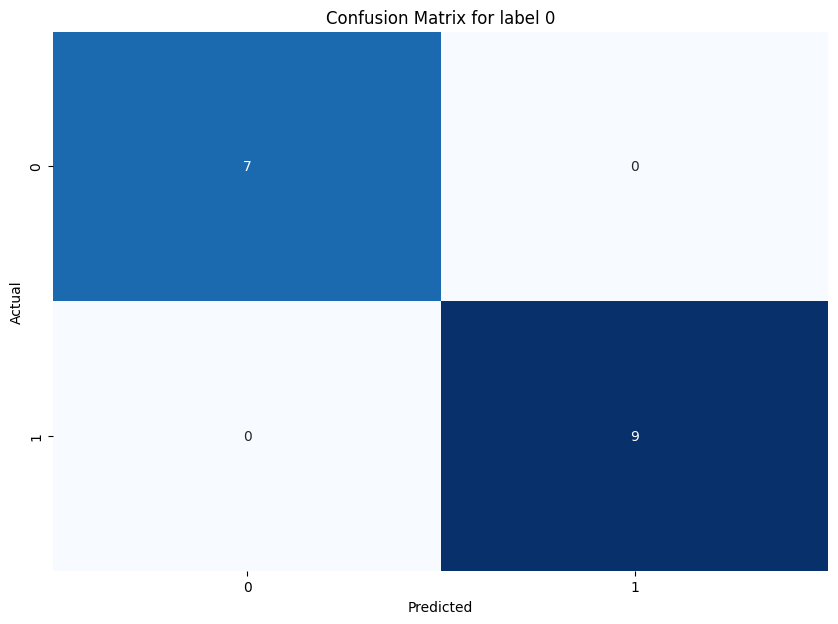

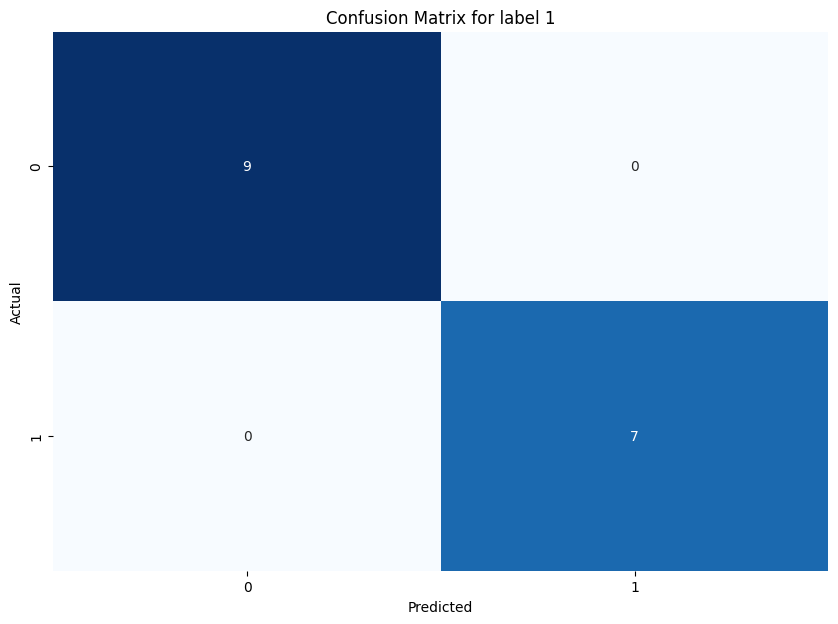

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         7

   micro avg       1.00      1.00      1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16
 samples avg       1.00      1.00      1.00        16

* report :               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         7

   micro avg       1.00      1.00      1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16
 samples avg       1.00      1.00      1.00        16

 ************** FIN CLASIFICACION  ************************************


In [18]:
#EValuar el modelo
report = my_rc.fit_evaluate (X_test, y_test)
##
print ('* report :', report)
print (f' ************** FIN CLASIFICACION  ************************************')



# ***MyDeepRC_ESN***



In [30]:
import torch
import numpy as np
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

from sklearn.metrics import silhouette_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import pdist, squareform
from sklearn.multiclass import OneVsRestClassifier
from base.tensorPCA import tensorPCA

class MyDeepRC:
    def __init__(self, config):
        self.config = config
        self.models = []
        layers_c = config ['layers']
        for layer_cfg in layers_c:
            # Creamos y añadimos una instancia de MyESN a la lista de modelos
            self.models.append (MyESN (layer_cfg))

        self._initialize_hyperparameters ()
        self._initialize_readout ()
        self._initialize_dimred_methods ()
        self._initialize_representation ()

    def _initialize_representation(self):
        # Initialize ridge regression model
        if self.mts_rep == 'output' or self.mts_rep == 'reservoir':
            self._ridge_embedding = Ridge (alpha = self.w_ridge_embedding, fit_intercept = True)

    def _initialize_hyperparameters(self):
        self.w_ridge                = self.config.get ('w_ridge')
        self.num_epochs             = self.config.get ('num_epochs')
        self.nonlinearity           = self.config.get ('nonlinearity')
        self.bidir                  = self.config.get ('bidir', False)
        self.threshold              = self.config.get ('threshold')
        self.n_drop                 = self._determine_n_drop (self.config.get ('n_drop')) # Initialize n_drop
        self.readout_type           = self.config.get ('readout_type')
        self.mts_rep                = self.config.get ('mts_rep')
        self.w_ridge_embedding      = self.config.get ('w_ridge_embedding')
        self.w_l2                   = self.config.get ('w_l2')
        self.svm_C                  = self.config.get ('svm_C')
        self.svm_kernel             = self.config.get ('svm_kernel')
        self.svm_gamma              = self.config.get ('svm_gamma')
        self.mlp_layout             = self.config.get ('mlp_layout')
        self.dimred_method          = self.config.get ('dimred_method')
        self.n_dim                  = self.config.get ('n_dim')
        self.mlp_batch_size         = self.config.get ('mlp_batch_size')
        self.mlp_learning_rate      = self.config.get ('mlp_learning_rate')
        self.mlp_learning_rate_type = self.config.get ('mlp_learning_rate_type')
        self.washout                = self.config.get ('washout')

    def _initialize_readout (self):
        if self.readout_type is not None:
            if self.readout_type == 'ridge':
                self.readout = Ridge (alpha = self.w_ridge)
            elif self.readout_type == 'svm':
                self.readout = SVC (C = self.svm_C, kernel = 'precomputed')
            elif self.readout_type == 'ovr':
                self.readout = OneVsRestClassifier (SVC (kernel = self.svm_kernel, C = self.svm_C, gamma = self.svm_gamma))
            elif self.readout_type == 'mlp':
                self.readout = MLPClassifier (
                    hidden_layer_sizes  = self.mlp_layout,
                    activation          = self.nonlinearity,
                    alpha               = self.w_l2,
                    batch_size          = self.mlp_batch_size,
                    learning_rate       = self.mlp_learning_rate_type,
                    learning_rate_init  = self.mlp_learning_rate ,
                    max_iter            = self.num_epochs,
                    early_stopping      = True,
                    validation_fraction = 0.001
                )
            else:
                raise RuntimeError('Invalid readout type')

    def _initialize_dimred_methods (self):

        dimred_method = self.config ['dimred_method']
        print(f'dimred_method:{dimred_method}')
        if dimred_method is not None:
          n_dim = self.config ['n_dim']
          if dimred_method == 'pca':
            self.dimred_methods = PCA(n_components=n_dim)
          elif dimred_method == 'tenpca':
            self.dimred_methods = tensorPCA(n_components=n_dim)
          elif dimred_method is None:
            self.dimred_methods  = None
          else:
            raise RuntimeError('Invalid dimred method ID')
        else:
          self.dimred_methods  = None

    def _determine_transients_to_drop (self, n_drop, input_timeline_size):
        """
            Determina los índices de los transitorios a eliminar según la configuración.

            Args:
            - n_drop (int): Número de transitorios a eliminar.
            - input_timeline_size (int): Tamaño total de la línea temporal de entrada.

            Returns:
            - transients_to_drop (list): Lista de índices de transitorios a eliminar.
        """
        transients_to_drop = []

        if n_drop > 0:
            if self.washout == 'init':
                transients_to_drop = list (range (n_drop))
            elif self.washout == 'rand':
                transients_to_drop = np.random.choice (input_timeline_size, size = n_drop, replace = False)
            else:
                transients_to_drop = list (range (n_drop))
        elif n_drop < 0:
            # Eliminar todos menos el último transitorio
            transients_to_drop = list (range (input_timeline_size - 1))
        else:
            # No eliminar ningún transitorio
            transients_to_drop = None

        return transients_to_drop

    def _get_states (self, input_data, bidir = False, evaluate = False):

        input_data       = torch.tensor (input_data, dtype = torch.float32) if not isinstance (input_data, torch.Tensor) else input_data
        states_per_layer = []
        current_input    = input_data

        for model in self.models:
            print (current_input.shape)

            n_drop             = 0
            transients_to_drop = None
            if not evaluate: # En fase de test o evaluación no se eliminan transitorios
                n_drop = min (self.n_drop, input_data.size (1))
                transients_to_drop = self._determine_transients_to_drop (n_drop, input_data.size (1))

            reservoir_state = self._process_transient_ESN (current_input, model, transients_to_drop)  # Corregido


            if bidir:
                input_data_b      = torch.tensor (current_input.numpy ()[:, ::-1, :].copy(), dtype = torch.float32)
                reservoir_state_b = self._process_transient_ESN (input_data_b, model, transients_to_drop) # Corregido

                mts_rep_state     = np.concatenate ((reservoir_state, reservoir_state_b), axis = 2)
            else:
                mts_rep_state = reservoir_state

            states_per_layer.append(mts_rep_state)  # Corregido
            current_input = reservoir_state

        return states_per_layer, transients_to_drop

    def _process_transient_ESN (self, X, model, transients_to_drop = None):
        n_serial = X.size (1)  # número de instantes de la serie temporal

        # Calcular el número de transitorios a eliminar
        num_transients_to_drop = len(transients_to_drop) if transients_to_drop is not None else 0
        # print (f'num_transients_to_drop:{num_transients_to_drop}')
        # Calcular el tamaño de reservoir_state considerando los transitorios a eliminar
        reservoir_state = torch.zeros ((X.size (0), n_serial  , model.reservoir_size), dtype = torch.float32)
        rc_state        = torch.zeros ((X.size (0), n_serial - num_transients_to_drop, model.reservoir_size), dtype = torch.float32)
        # print (f'reservoir_state:{reservoir_state.size()}')
        # print (f'rc_state:{rc_state.size()}')
        reservoir_index = 0  # Índice para seguir el estado del reservorio

        for t in range (n_serial):
            input_sequence = X [:, t, :].float()
            # print (f't:{t}')

            if transients_to_drop is not None and t in transients_to_drop:
                continue # Skip processing this transient

            # Process input_sequence with the ESN model
            reservoir_state = model (input_sequence, reservoir_state, t)
            # print (f'* reservoir_state:{reservoir_state.size()}')


            rc_state [:,reservoir_index,:] = reservoir_state [:,t,:]
            reservoir_index += 1

            # print (f'* rc_state:{rc_state.size()}')

        if len(rc_state) == 0:
            return None

        return rc_state

    def _eliminate_transients (self, reservoir_state, num_samples):
        if self.n_drop > 0:
            keep_mask = np.ones (num_samples, dtype = bool)
            keep_mask[:self.n_drop] = False
            state_matrix = reservoir_state [:, keep_mask, :]
        else:
            state_matrix = reservoir_state

        return state_matrix

    def fit (self, input_data, target_data = None):

        with torch.no_grad ():
            self.states_per_layer, n_tr_drop = self._get_states (input_data, self.bidir, evaluate = False)



        self.final_states = self.states_per_layer [-1]
        self.red_states   = self._reduce_dimensionality (self.final_states)
        self.input_repr   = self._generate_representation (input_data, self.red_states)

        if target_data is None or self.readout_type is None:
            self.output_rc_layer = self.input_repr
        else:
            self.output_rc_layer = self._apply_readout (self.input_repr, target_data)

        return self.states_per_layer, self.final_states, self.red_states, self.input_repr, self.output_rc_layer

    def _reduce_dimensionality(self, states):
        dimred_method = self.dimred_methods

        if dimred_method:
          if isinstance(dimred_method, PCA):
            n_samples  = states.shape [0]
            r_states   = states.reshape(-1, states.shape[2])
            red_states = dimred_method.fit_transform(r_states)
            red_states = red_states.reshape(n_samples, -1, red_states.shape[1])
          elif isinstance (dimred_method, tensorPCA):
            red_states = dimred_method.fit_transform (states)
          else:
            red_states = states
        else:
            red_states = states

        return np.real(red_states)

    def _generate_representation(self, input_data, red_states):
        coeff_tr = []
        biases_tr = []

        if self.mts_rep == 'output':
            if self.bidir:
                input_data = np.concatenate((input_data, input_data[:, ::-1, :]), axis=2)
            n_idx = self.n_drop if self.n_drop >= 0 else 0
            for i in range(input_data.shape[0]):
                self._ridge_embedding.fit(red_states[i, 0:-1, :], input_data[i, n_idx:-1, :])
                coeff_tr.append(self._ridge_embedding.coef_.ravel())
                biases_tr.append(self._ridge_embedding.intercept_.ravel())
            input_repr = np.concatenate((np.vstack(coeff_tr), np.vstack(biases_tr)), axis=1)
        elif self.mts_rep == 'reservoir':
            for i in range(input_data.shape[0]):
                self._ridge_embedding.fit(red_states[i, 0:-1, :], red_states[i, 1:, :])
                coeff_tr.append(self._ridge_embedding.coef_.ravel())
                biases_tr.append(self._ridge_embedding.intercept_.ravel())
            input_repr = np.concatenate((np.vstack(coeff_tr), np.vstack(biases_tr)), axis=1)
        elif self.mts_rep == 'last':
            input_repr = red_states[:, -1, :]
        elif self.mts_rep == 'mean':
            input_repr = np.mean(red_states, axis=1)
        else:
            raise ValueError("Invalid mts_rep type")

        return input_repr

    def _determine_n_drop (self, n_drop_config):
        if n_drop_config is None:
            return 0
        elif n_drop_config == 'all':
            return -1
        else:
            return n_drop_config

    def _apply_readout(self, input_repr, target_data):
      if self.readout_type is not None:
        if self.readout_type == 'lin':
            return self.readout.fit(input_repr, target_data)
        elif self.readout_type == 'svm':
            Ktr = squareform(pdist(input_repr, metric='sqeuclidean'))
            Ktr = np.exp(-self.svm_gamma * Ktr)
            return self.readout.fit(Ktr, np.argmax(target_data, axis=1))
        elif self.readout_type == 'ovr':
            ovr_classifier = OneVsRestClassifier(self.readout)
            return ovr_classifier.fit(input_repr, np.argmax(target_data, axis=1))
        elif self.readout_type == 'mlp':
            return self.readout.fit(input_repr, np.argmax(target_data, axis=1))
        else:
            raise RuntimeError('Invalid readout type')

deep_esn_config = {
    'seed': 1,
    'layers': [
        {  'init_type':'orthogonal',
            'init_std':0.01,
            'init_mean':0,
            'input_size': 10,
            'n_internal_units': 480,
            'spectral_radius': 0.4,
            'leak': 0.8,
            'input_scaling': 1.0,
            'connectivity': 0.5,
            'noise_level': 0.01,
            'nonlinearity': 'relu',
            'use_input_bias': True,
            'use_input_layer': True,
            'circle': False,
            'plasticity_synaptic':None,
            'theta_m':0.01,
            'plasticity_intrinsic':None,
            'learning_rate':0.9,
            'new_activation_function':'tanh',
            'excitability_factor':0.01,
            'device':'cpu'
        },
        { 'init_type':'orthogonal',
            'init_std':0.01,
            'init_mean':0,
            'input_size': 480,
            'n_internal_units': 240,
            'spectral_radius': 0.6,
            'leak': 0.5,
            'input_scaling': 1.0,
            'connectivity': 0.4,
            'noise_level': 0.1,
            'nonlinearity': 'relu',
            'use_input_bias': True,
            'use_input_layer': True,
            'circle': False,
            'plasticity_synaptic':None,
            'theta_m':0.01,
            'plasticity_intrinsic':None,
            'learning_rate':0.9,
            'new_activation_function':'tanh',
            'excitability_factor':0.01,
            'device':'cpu'
        },
        { 'init_type':'orthogonal',
            'init_std':0.01,
            'init_mean':0,
            'input_size': 240,
            'n_internal_units': 120,
            'spectral_radius': 0.4,
            'leak': 0.5,
            'input_scaling': 1.0,
            'connectivity': 0.8,
            'noise_level': 0.1,
            'nonlinearity': 'relu',
            'use_input_bias': True,
            'use_input_layer': True,
            'circle': False,
            'plasticity_synaptic':None,
            'theta_m':0.01,
            'plasticity_intrinsic':None,
            'learning_rate':0.9,
            'new_activation_function':'tanh',
            'excitability_factor':0.01,
            'device':'cpu'
        }
    ],
    'nonlinearity': 'tanh',  # 'relu','tanh' para mlp
    'use_input_bias': True,
    'readout_type': None,  # Ridge regression
    'w_ridge': 5.0,
    'n_drop': None,
    'washout':'init',
    'mts_rep':'reservoir',
    'learning_rate': 0.1,
    'random_state': 1,
    'bidir': False,
    'circle': False,
    'dimred_method': 'tenpca',
    'n_dim': 44,
    'threshold':0.5,
    'svm_kernel': 'linear',
    'svm_gamma': 0.005,
    'mlp_layout': (100, 100),
    'num_epochs': 2000,
    'mlp_batch_size':32,
    'mlp_learning_rate':0.01,
    'mlp_learning_rate_type':'constant', # 'constant' or 'adaptive'
    'w_l2': 0.001,
    'max_depth':12,
    'n_estimators':100,
    'w_ridge_embedding':10.0,
    'device':'cpu'
}
import numpy as np

deep_rc = MyDeepRC (deep_esn_config)
# EStado de cada capa interna del RC, estados de la ultima capa interna dle RC, estado con reducción dimensionalidad, Representacion interna del RC, Readout
states_per_layer, final_states, red_states, input_repr, output_rc_layer = deep_rc.fit(Xo)
print ('******************FIN Entrenamiento Deep RC*************')
print('output_rc_layer:', output_rc_layer.shape)
print('final_states:', final_states.shape)
print('states_per_layer:', len(states_per_layer))
print('states_per_layer:', states_per_layer[0].shape)
print('red_states:', red_states.shape)
print('input_repr:', input_repr.shape)


# Evaluar el modelo

dimred_method:tenpca
torch.Size([40, 2000, 10])
torch.Size([40, 2000, 480])
torch.Size([40, 2000, 240])
******************FIN Entrenamiento Deep RC*************
output_rc_layer: (40, 1980)
final_states: torch.Size([40, 2000, 120])
states_per_layer: 3
states_per_layer: torch.Size([40, 2000, 480])
red_states: (40, 2000, 44)
input_repr: (40, 1980)


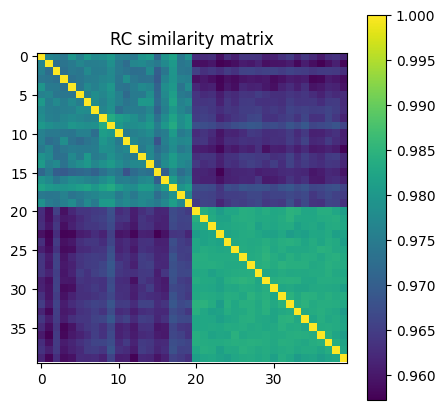

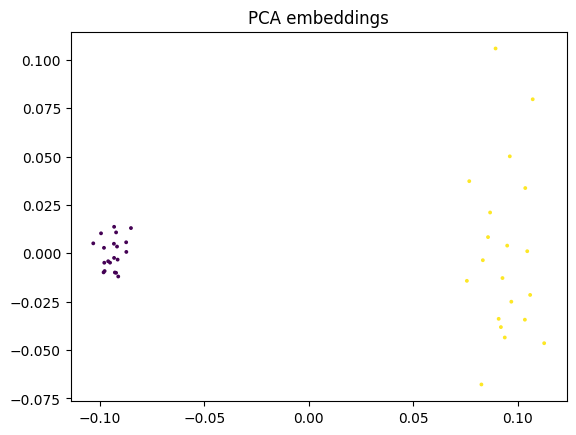

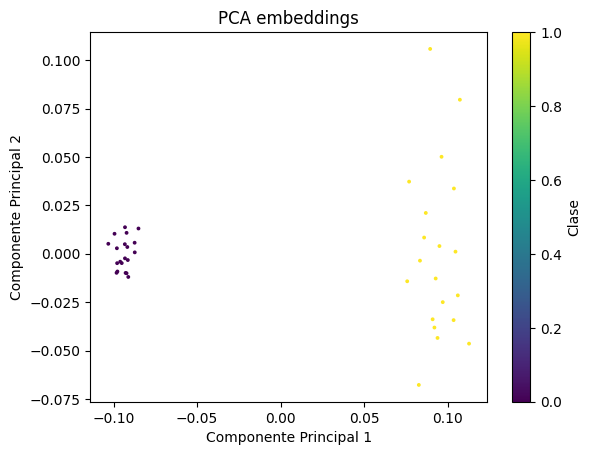

Varianza explicada por el Componente Principal 1: 0.9025
Varianza explicada por el Componente Principal 2: 0.0975
Found 2 clusters
Normalized Mutual Information (v-score): 1.000


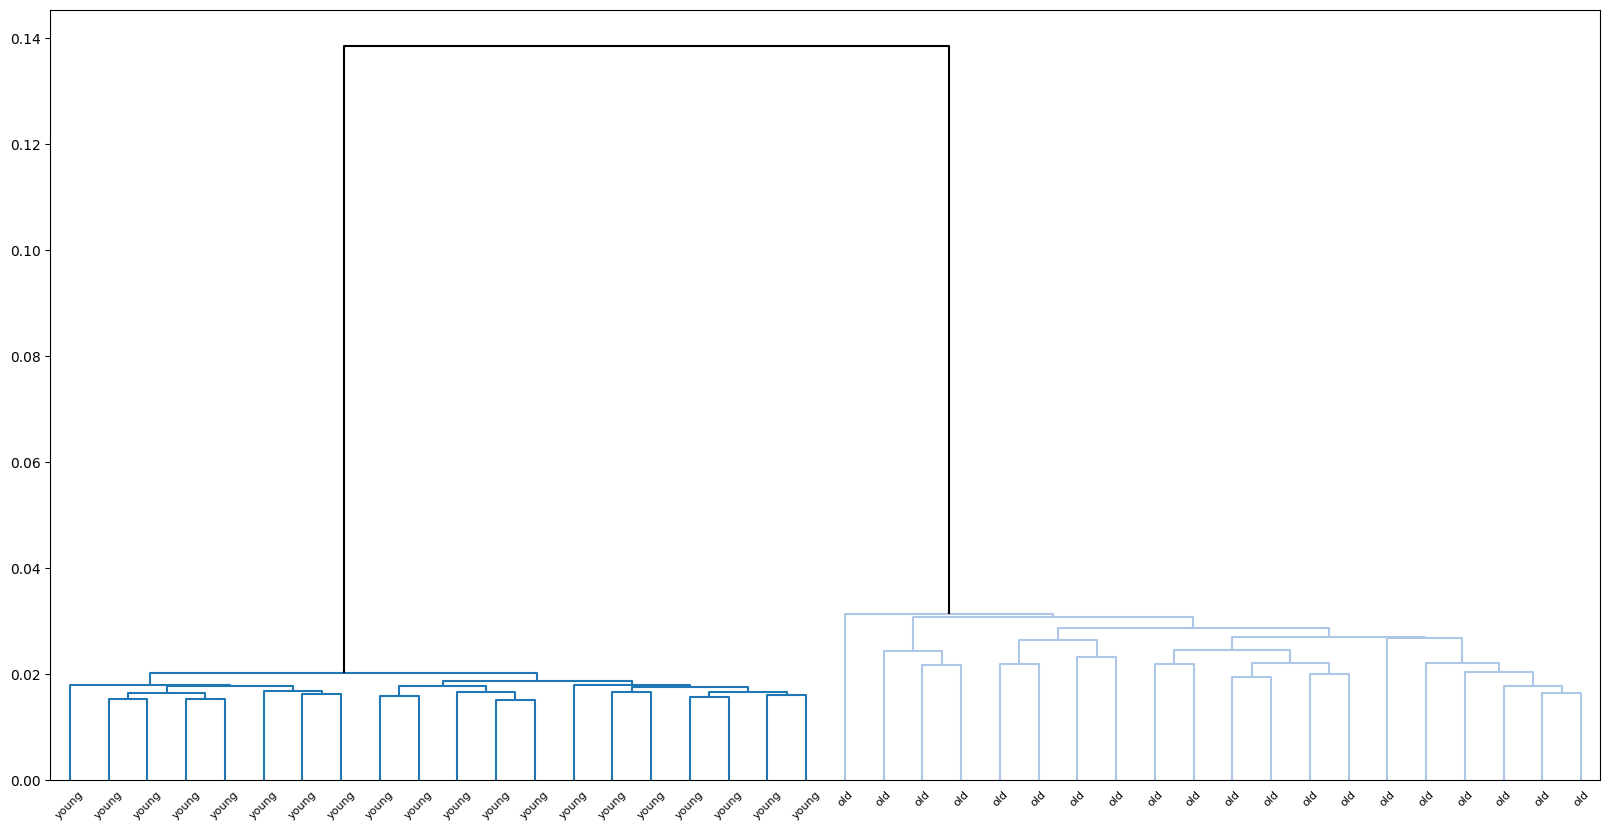

N. clusters:  2
Confusion Matrix:
[[20  0]
 [ 0 20]]


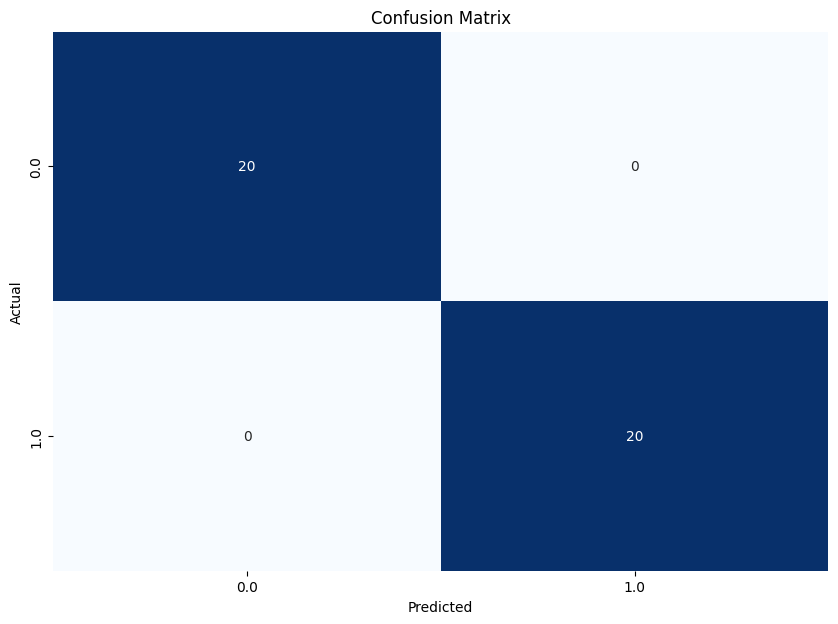

Frequency: [0.5 0.5]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0


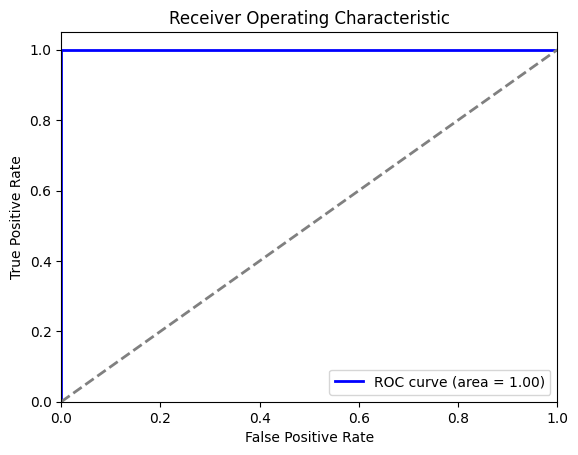

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [32]:

import scipy.io
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm

from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.metrics import v_measure_score
from sklearn.decomposition import KernelPCA
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score,
                             precision_score, recall_score, f1_score,
                             accuracy_score, classification_report)

# Set the colormap for the histogram plot
cmap = cm.tab20(np.linspace(0, 1, 12))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

# Fix the random seed for reproducibility
np.random.seed(0)


mts_representations_o = output_rc_layer
# Compute a similarity matrix from the cosine similarity of the representations
similarity_matrix = cosine_similarity (mts_representations_o)

# Normalize the similarity in [0,1]
similarity_matrix = (similarity_matrix + 1.0)/2.0

# Plot similarity matrix
fig =  plt.figure(figsize=(5,5))
h = plt.imshow(similarity_matrix)
plt.title("RC similarity matrix")
plt.colorbar(h)
plt.show()

# Reducción de dimensionalidad con Kernel PCA
kpca = KernelPCA(n_components=2, kernel='precomputed')
embeddings_pca = kpca.fit_transform(similarity_matrix)
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=Y[:,0], s=3)
plt.title("PCA embeddings")
plt.show()

# Reducción de dimensionalidad con Kernel PCA
# kpca = KernelPCA(kernel='precomputed')
# embeddings_pca = kpca.fit_transform(similarity_matrix)

# Obtener los autovalores (varianza explicada)
eigenvalues = kpca.eigenvalues_

# Calcular la varianza total (suma de los autovalores)
total_variance = np.sum(eigenvalues)

# Calcular la varianza explicada por cada componente
explained_variance_ratio = eigenvalues / total_variance

# Graficar los resultados (solo para los dos primeros componentes)
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=Y[:, 0], s=3)
plt.title("PCA embeddings")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label='Clase')
plt.show()

# Mostrar la varianza explicada por cada componente
for i, ev in enumerate(explained_variance_ratio):
    print(f"Varianza explicada por el Componente Principal {i+1}: {ev:.4f}")

# Compute Dissimilarity matrix
Dist = 1.0 - similarity_matrix
np.fill_diagonal(Dist, 0) # due to numerical errors, the diagonal might not be 0

# Hierarchical clustering
distArray = ssd.squareform (Dist)
Z = linkage(distArray, 'ward')
clust = fcluster(Z, t = 0.04, criterion="distance")
print("Found %d clusters"%len(np.unique(clust)))
# Evaluate the agreement between class and cluster labels
nmi = v_measure_score(Y[:,0], clust)
print("Normalized Mutual Information (v-score): %.3f"%nmi)

# Plot dendrogram
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=0.04, labels = words_labels, above_threshold_color='k')
plt.show()
print("N. clusters: ", np.unique(dn['color_list']).shape[0]-1)


# Obtener las etiquetas reales y predichas
labels      = labels_auto [:,0]   # Asegúrate de que 'labels_auto' contenga las etiquetas correctas
labels_pred = clust - 1           # Este es solo un ejemplo, reemplaza con tus etiquetas de clustering jerárquico

# Calcular la matriz de confusión y métricas relacionadas
evaluate_clustering (labels, labels_pred)

# Uso valores cantidad energia en cada banda


- si se observan **valores altos de onda delta junto con valores bajos en otras bandas** de frecuencia, podría indicar un **estado de reposo o sueño**, mientras que una **distribución más equilibrada de energía entre diferentes bandas podría indicar actividad mental**.

- La **onda alfa** está relacionada con la **falta de actividad cerebral** (Blasi & Roig). Es una onda con una frecuencia de entre 8-12 Hz. Cuando una persona toma un **descanso después de una actividad o cuando medita o da un paseo**, se originan ondas alfa.  

- las **ondas beta** se generan cuando el **cerebro está activo y concentrado en actividades mentales**, genera . Este tipo de ondas son de una amplitud más baja y una frecuencia de entre 12-30 Hz. Por ejemplo, durante una conversación intensa o un debate, o dando una clase un profesor, se genera la onda beta.

- las **ondas theta** se emiten cuando un individuo está tan relajado que comienza a soñar despierto,  . Estas ondas surgen, por ejemplo, cuando se lleva un rato conduciendo y resulta imposible recordar los últimos kilómetros recorridos, es decir, **durante esas actividades que realizamos automáticamente**, como ducharse. Las ondas theta tienen una frecuencia de entre 4-8 Hz. Este estado mental es muy positivo para la **generación de ideas**.

- las **ondas delta** se originan en el momento de **sueño profundo**. Son las ondas de menor frecuencia, entre 0,5-4 Hz. Cuando se apaga la luz y se cierran los ojos para dormir, las ondas cerebrales descienden en frecuencia hasta la onda delta, en la que se alcanza el sueño profundo (Herrmann, 1990)

- La **onda gamma** es la más rápida, con frecuencias de 30-42 Hz. Esta onda a menudo se ha señalado como especialmente relevante para la **conciencia** (YuvalGreenberg, Tomer, Keren, Nelken, & Deouell, 2008) y relacionada con **experiencias de meditación** (Braboszcz, Cahn, Levy, Fernandez, & Delorme, 2017).



|onda| freceuncia |  estado|
|-----|-----------|---------|
|Delta	|1–4 |	Sueño, reparación, resolución de problemas complejos, inconsciencia, profunda inconsciencia |
|Theta	|4–8 |	Creatividad, percepción, estados profundos, inconsciencia, estado meditativo óptimo, depresión, ansiedad, distracción |
|Alpha	|8–13 |	Alerta y tranquilidad, preparación, meditación, profundamente relajado.
|Alpha inferior	|8–10 |	Recordando |
|Alpha superior	|10–13 |	Optimizar el rendimiento cognitivo. SMR (ritmo sensoriomoto)	13–15	Estado de alerta mental, relajación física |
|Beta	|15–20 |	 Pensar, enfocar, atención sostenida, tensión, estado de alerta, emoción. |
|Beta alto	|20-32 |	Intensidad, estado de hiperalerta, ansiedad. |
|Gamma	|32–100 |	Aprendizaje, procesamiento cognitivo, tareas de resolución de problemas, agudeza mental, actividad cerebral, organización del cerebro. |


In [ ]:
import numpy as np
bandas_frecuencia = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30),
        'Gamma': (30, 100)
    }
# Definir los valores para cada sujeto
sujetos = {
    1: [31856087.50, 5451.81, 5451.80, 24533.07, 46340.29],
    2: [10104617.19, 1729.29, 1729.29, 7781.79, 14698.94],
    3: [875181.64, 149.78, 149.78, 674.00, 1273.11],
    4: [415708.94, 71.14, 71.14, 320.15, 604.72],
    5: [212317.07, 36.34, 36.34, 163.51, 308.85],
    6: [1274546.97, 218.12, 218.12, 981.56, 1854.05],
    7: [1231136.62, 210.70, 210.69, 948.13, 1790.91],
    8: [2317185.55, 396.56, 396.56, 1784.52, 3370.75]
}

# Crear el dataset X y asignar etiquetas
X = []
y = []
for sujeto, valores in sujetos.items():
    X.append(valores)
    if sujeto <= 4:
        y.append(0)  # Etiqueta 0 para sujetos jóvenes
    else:
        y.append(1)  # Etiqueta 1 para sujetos mayores

# Convertir a matrices numpy
X = np.array(X)
y = np.array(y)

print("Dataset X:")
print(X)
print("Etiquetas y:")
print(y)


Dataset X:
[[3.18560875e+07 5.45181000e+03 5.45180000e+03 2.45330700e+04
  4.63402900e+04]
 [1.01046172e+07 1.72929000e+03 1.72929000e+03 7.78179000e+03
  1.46989400e+04]
 [8.75181640e+05 1.49780000e+02 1.49780000e+02 6.74000000e+02
  1.27311000e+03]
 [4.15708940e+05 7.11400000e+01 7.11400000e+01 3.20150000e+02
  6.04720000e+02]
 [2.12317070e+05 3.63400000e+01 3.63400000e+01 1.63510000e+02
  3.08850000e+02]
 [1.27454697e+06 2.18120000e+02 2.18120000e+02 9.81560000e+02
  1.85405000e+03]
 [1.23113662e+06 2.10700000e+02 2.10690000e+02 9.48130000e+02
  1.79091000e+03]
 [2.31718555e+06 3.96560000e+02 3.96560000e+02 1.78452000e+03
  3.37075000e+03]]
Etiquetas y:
[0 0 0 0 1 1 1 1]


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2, random_state = 42)

# Inicializar el clasificador SVM
svm_classifier = SVC (kernel='linear', random_state = 42)  # Selecciona el tipo de kernel según tus necesidades (lineal, RBF, polinómico, etc.)

# Entrenar el clasificador SVM
svm_classifier.fit (X_train, y_train)

# Predecir las etiquetas de clase para los datos de prueba
y_pred = svm_classifier.predict (X_test)

# Calcular la precisión del clasificador
accuracy = accuracy_score (y_test, y_pred)
print("Precisión del clasificador SVM:", accuracy)